In [1]:
# General System Imports
import datetime
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Scientific libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from scipy.spatial import procrustes
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import squareform
import scipy.io

# Local code.
sys.path.append(os.path.join(os.getcwd(), "..", "code"))
from peck_data import load_pecking_days, windows_by_reward


# The standard color table of Etho Call-types
callColor = {
        'Be':(0/255.0, 230/255.0, 255/255.0),
        'BE':(0/255.0, 230/255.0, 255/255.0),
        'Tu':(255/255.0, 200/255.0, 65/255.0),
        'TU':(255/255.0, 200/255.0, 65/255.0),
        'Th':(255/255.0, 150/255.0, 40/255.0),
        'TH':(255/255.0, 150/255.0, 40/255.0),
        'Alarm':(255/255.0, 200/255.0, 65/255.0),
        'Di':(255/255.0, 105/255.0, 15/255.0),
        'DI':(255/255.0, 105/255.0, 15/255.0),
        'Ag':(255/255.0, 0/255.0, 0/255.0),
        'AG':(255/255.0, 0/255.0, 0/255.0),
        'Fight':(255/255.0, 105/255.0, 15/255.0),
        'Wh':(255/255.0, 180/255.0, 255/255.0),
        'WH':(255/255.0, 180/255.0, 255/255.0),
        'Ne':(255/255.0, 100/255.0, 255/255.0),
        'NE':(255/255.0, 100/255.0, 255/255.0),
        'Te':(140/255.0, 100/255.0, 185/255.0),
        'TE':(140/255.0, 100/255.0, 185/255.0),
        'Soft':(255/255.0, 180/255.0, 255/255.0),
        'DC':(100/255.0, 50/255.0, 200/255.0),
        'LT':(0/255.0, 95/255.0, 255/255.0),
        'Loud':(100/255.0, 50/255.0, 200/255.0),
        'song':(0, 0, 0),
        'So':(0,0,0), 
        'SO':(0,0,0),
        'In': (0.49,0.60,0.55), 
        'Mo':(0.69,0.39,0.39),
        'Ri':(0,255/255.0,0),
        'WC': (.25, .25, .25)}

In [2]:
# The diretory for saving figures - Change to place of your choice
figDir = os.path.expanduser('~/Desktop/')

# The behavioral data is stored in csv files in the data directory
DATADIR = "../data/behavior/"
RESULTSDIR = "../results/"

In [3]:
def compute_odds_ratio(group, versus, *args): # Reward DC, All Unrewarded -> Unreward So, Reward DC
    dums = [
        [len(group[group["Response"] == True]),
        len(group[group["Response"] == False])],
        [len(versus[versus["Response"] == True]),
        len(versus[versus["Response"] == False])]
    ]
#     if dums[1][0] == 0 and args[0] == "less":
#         dums[1][0] += 1
#     if dums[0][0] == 0 and args[0] == "greater":
#         dums[0][0] += 1
    _, pvalue = fisher_exact(dums, *args)

    for i in range(2):
        for j in range(2):
            if dums[i][j] == 0:
                dums[i][j] += 1

    return fisher_exact(dums, *args)[0], pvalue
 

def set_oddsratio_yticks(ax, biggest, ylabels=True):
    ax.set_ylim(np.power(2., -biggest), np.power(2., biggest))
    ax.set_yscale("log")
    
    powers = np.arange(0, biggest + 1)
    n = len(powers)
    powers = powers[::n // 6 + 1]
    vals = np.concatenate([-powers, powers[1:]])

    ticks = np.power(2., vals)
    labels = [r"x{:d}".format(int(2 ** v)) if v >= 0 else r"x1/{:d}".format(int(2 ** -v)) for v in vals]
    
    if ylabels:
        ax.set_ylabel("Odds Ratio", fontsize=10)
    # ax.set_xlabel("Trial", fontsize=12)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels, fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.hlines(1, *plt.xlim(), linestyle="--", zorder=-1)


In [4]:
def cached_load(bird, date, date_end=None, call_type = None, minRT = 0):
    if (bird, date, date_end, minRT) not in cached_load._cache:
        print('Needs to load data')
        if date_end is not None:
            blocks, stim_blocks = load_pecking_days(os.path.join(DATADIR, bird), date_range=(date, date_end), call_type = call_type, minRT = minRT)
            cached_load._cache[(bird, date, date_end, minRT)] = (blocks, stim_blocks)
            print(blocks)
        else:
            blocks, stim_blocks = load_pecking_days(os.path.join(DATADIR, bird, date.strftime("%d%m%y")), call_type = call_type, minRT = minRT)
            cached_load._cache[(bird, date, date_end, minRT)] = (blocks, stim_blocks)
            print(blocks)

    return cached_load._cache[(bird, date, date_end, minRT)]

cached_load._cache = {}



In [5]:
# manually found all start and end dates for all birds on all calls
bird_dates = {
    "HpiHpi1625F" : {
        "Te": {"start": datetime.date(2017, 4, 5), "end": datetime.date(2017, 4, 7)},
        "Tu": {"start": datetime.date(2017, 4, 8), "end": datetime.date(2017, 4, 9)},
        "Di": {"start": datetime.date(2017, 4, 10), "end": datetime.date(2017, 4, 12)},
        "Th": {"start": datetime.date(2017, 4, 13), "end": datetime.date(2017, 4, 16)},
        "Ag": {"start": datetime.date(2017, 4, 17), "end": datetime.date(2017, 4, 18)},
        "Wh": {"start": datetime.date(2017, 4, 19), "end": datetime.date(2017, 4, 20)},
        "So": {"start": datetime.date(2017, 4, 21), "end": datetime.date(2017, 4, 21)},
        "Be": {"start": datetime.date(2017, 4, 22), "end": datetime.date(2017, 4, 22)},
        "DC": {"start": datetime.date(2017, 4, 23), "end": datetime.date(2017, 4, 24)},
        "Ne": {"start": datetime.date(2017, 4, 25), "end": datetime.date(2017, 4, 26)},
        "LT": {"start": datetime.date(2017, 4, 27), "end": datetime.date(2017, 4, 28)},
    },
    # This bird injured her leg during LT tests on 20/26
   # "LblGra2025F" : {
   #    "Te": {"start": datetime.date(2016, 10, 16), "end": datetime.date(2016, 10, 19)},
   #    "Tu": {"start": datetime.date(2016, 10, 29), "end": datetime.date(2016, 10, 31)},
   #    "Di": {"start": datetime.date(2016, 11, 2), "end": datetime.date(2016, 11, 6)},
   #    "Th": {"start": datetime.date(2016, 10, 20), "end": datetime.date(2016, 10, 22)},
   #    "Ag": {"start": datetime.date(2016, 11, 1), "end": datetime.date(2016, 11, 1)},
   #    "Wh": {"start": datetime.date(2016, 10, 12), "end": datetime.date(2016, 10, 13)},
   #    "So": {"start": datetime.date(2016, 10, 14), "end": datetime.date(2016, 10, 15)},
   #    "Be": {"start": datetime.date(2016, 10, 23), "end": datetime.date(2016, 10, 24)},
   #    "DC": {"start": datetime.date(2016, 10, 10), "end": datetime.date(2016, 10, 11)},
   #    "Ne": {"start": datetime.date(2016, 11, 7), "end": datetime.date(2016, 11, 12)},
   #    "LT": {"start": datetime.date(2016, 10, 25), "end": datetime.date(2016, 10, 28)},
   # },
    "HpiHpi1918M" : {
        "Te": {"start": datetime.date(2017, 2, 28), "end": datetime.date(2017, 3, 1)},
        "Tu": {"start": datetime.date(2017, 2, 26), "end": datetime.date(2017, 2, 27)},
        "Di": {"start": datetime.date(2017, 2, 14), "end": datetime.date(2017, 2, 15)},
        "Th": {"start": datetime.date(2017, 2, 12), "end": datetime.date(2017, 2, 13)},
        "Ag": {"start": datetime.date(2017, 2, 23), "end": datetime.date(2017, 2, 23)},
        "Wh": {"start": datetime.date(2017, 2, 20), "end": datetime.date(2017, 2, 21)},
        "So": {"start": datetime.date(2017, 2, 25), "end": datetime.date(2017, 2, 25)},
        "Be": {"start": datetime.date(2017, 2, 16), "end": datetime.date(2017, 2, 16)},
        "DC": {"start": datetime.date(2017, 2, 19), "end": datetime.date(2017, 2, 19)},
        "Ne": {"start": datetime.date(2017, 2, 24), "end": datetime.date(2017, 2, 24)},
        "LT": {"start": datetime.date(2017, 2, 22), "end": datetime.date(2017, 2, 22)},
    },
    "HpiGra1242F" : {
        "Te": {"start": datetime.date(2016, 12, 4), "end": datetime.date(2016, 12, 6)},
        "Tu": {"start": datetime.date(2016, 11, 30), "end": datetime.date(2016, 11, 30)},
        "Di": {"start": datetime.date(2016, 12, 17), "end": datetime.date(2016, 12, 17)},
        "Th": {"start": datetime.date(2016, 12, 7), "end": datetime.date(2016, 12, 9)},
        "Ag": {"start": datetime.date(2016, 12, 10), "end": datetime.date(2016, 12, 10)},
        "Wh": {"start": datetime.date(2016, 12, 2), "end": datetime.date(2016, 12, 3)},
        "So": {"start": datetime.date(2016, 11, 11), "end": datetime.date(2016, 11, 12)},
        "Be": {"start": datetime.date(2016, 11, 13), "end": datetime.date(2016, 11, 14)},
        "DC": {"start":datetime.date(2016, 12, 1), "end": datetime.date(2016, 12, 1)},
        "Ne": {"start": datetime.date(2016, 12, 13), "end": datetime.date(2016, 12, 16)},
        "LT": {"start": datetime.date(2016, 12, 11), "end": datetime.date(2016, 12, 12)},
    },
    "GreLbl3131M" : {
       "Te": {"start": datetime.date(2016, 12, 18), "end": datetime.date(2016, 12, 21)},
       "Tu": {"start": datetime.date(2016, 12, 24), "end": datetime.date(2016, 12, 25)},
       "Di": {"start": datetime.date(2016, 12, 17), "end": datetime.date(2016, 12, 17)},
       "Th": {"start": datetime.date(2017, 1, 19), "end": datetime.date(2017, 1, 23)},
       "Ag": {"start": datetime.date(2017, 1, 3), "end": datetime.date(2017, 1, 6)},
       "Wh": {"start": datetime.date(2016, 12, 14), "end": datetime.date(2016, 12, 15)},
       "So": {"start": (datetime.date(2016, 12, 12), datetime.date(2016, 12, 16)) , 
              "end": (datetime.date(2016, 12, 12), datetime.date(2016, 12, 16)) },
       "Be": {"start": datetime.date(2016, 12, 13), "end": datetime.date(2016, 12, 13)},
       "DC": {"start": datetime.date(2017, 1, 24), "end": datetime.date(2017, 1, 27)},
       "Ne": {"start": datetime.date(2016, 12, 22), "end": datetime.date(2016, 12, 23)},
       "LT": {"start": datetime.date(2017, 1, 7), "end": datetime.date(2017, 1, 10)},
    },
    "GreLbl1635F" : {
        "Te": {"start": datetime.date(2017, 5, 24), "end": datetime.date(2017, 5, 24)},
        "Tu": {"start": datetime.date(2017, 5, 14), "end": datetime.date(2017, 5, 15)},
        "Di": {"start": datetime.date(2017, 5, 16), "end": datetime.date(2017, 5, 17)},
        "Th": {"start": datetime.date(2017, 5, 21), "end": datetime.date(2017, 5, 21)},
        "Ag": {"start": datetime.date(2017, 5, 18), "end": datetime.date(2017, 5, 18)},
        "Wh": {"start": datetime.date(2017, 5, 12), "end": datetime.date(2017, 5, 13)},
        "So": {"start": datetime.date(2017, 5, 20), "end": datetime.date(2017, 5, 20)},
        "Be": {"start": datetime.date(2017, 5, 19), "end": datetime.date(2017, 5, 19)},
        "DC": {"start": datetime.date(2017, 5, 10), "end": datetime.date(2017, 5, 11)},
        "Ne": {"start": datetime.date(2017, 5, 8),  "end": datetime.date(2017, 5, 9)},
        "LT": {"start": datetime.date(2017, 5, 22), "end": datetime.date(2017, 5, 23)},
    },
    "GraLbl4833M" : {
        "Te": {"start": datetime.date(2017, 4, 9), "end": datetime.date(2017, 4, 9)},
        "Tu": {"start": datetime.date(2017, 4, 12), "end": datetime.date(2017, 4, 13)},
        "Di": {"start": datetime.date(2017, 4, 17), "end": datetime.date(2017, 4, 18)},
        "Th": {"start": datetime.date(2017, 4, 6), "end": datetime.date(2017, 4, 6)},
        "Ag": {"start": datetime.date(2017, 4, 14), "end": datetime.date(2017, 4, 16)},
        "Wh": {"start": datetime.date(2017, 4, 19), "end": datetime.date(2017, 4, 20)},
        "So": {"start": datetime.date(2017, 4, 8), "end": datetime.date(2017, 4, 8)},
        "Be": {"start": datetime.date(2017, 4, 10), "end": datetime.date(2017, 4, 11)},
        "DC": {"start": datetime.date(2017, 4, 5), "end": datetime.date(2017, 4, 5)},
        "Ne": {"start": datetime.date(2017, 4, 21), "end": datetime.date(2017, 4, 21)},
        "LT": {"start": datetime.date(2017, 4, 7), "end": datetime.date(2017, 4, 7)},
    },
    "GraLbl1718F" : {
        "Te": {"start": datetime.date(2017, 4, 9), "end": datetime.date(2017, 4, 9)},
        "Tu": {"start": datetime.date(2017, 4, 4), "end": datetime.date(2017, 4, 5)},
        "Di": {"start": datetime.date(2017, 4, 12), "end": datetime.date(2017, 4, 12)},
        "Th": {"start": datetime.date(2017, 4, 6), "end": datetime.date(2017, 4, 6)},
        "Ag": {"start": datetime.date(2017, 4, 10), "end": datetime.date(2017, 4, 11)},
        "Wh": {"start": datetime.date(2017, 4, 8), "end": datetime.date(2017, 4, 8)},
        "So": {"start": datetime.date(2017, 3, 30), "end": datetime.date(2017, 3, 30)},
        "Be": {"start": datetime.date(2017, 3, 29), "end": datetime.date(2017, 3, 29)},
        "DC": {"start": datetime.date(2017, 4, 7), "end": datetime.date(2017, 4, 7)},
        "Ne": {"start": datetime.date(2017, 3, 31), "end": datetime.date(2017, 3, 31)},
        "LT": {"start": datetime.date(2017, 4, 1), "end": datetime.date(2017, 4, 3)},
    },
    # Removing because of no Ne Call
    "GraGre0917M" : { 
        "Te": {"start": datetime.date(2017, 3, 28), "end": datetime.date(2017, 3, 28)},
        "Tu": {"start": datetime.date(2017, 3, 27), "end": datetime.date(2017, 3, 27)},
        "Di": {"start": datetime.date(2017, 4, 1), "end": datetime.date(2017, 4, 1)},
        "Th": {"start": datetime.date(2017, 4, 3), "end": datetime.date(2017, 4, 4)},
        "Ag": {"start": datetime.date(2017, 3, 31), "end": datetime.date(2017, 3, 31)},
        "Wh": {"start": datetime.date(2017, 4, 8), "end": datetime.date(2017, 4, 8)},
        "So": {"start": datetime.date(2017, 4, 6), "end": datetime.date(2017, 4, 6)},
        "Be": {"start": datetime.date(2017, 3, 29), "end": datetime.date(2017, 3, 29)},
        "DC": {"start": datetime.date(2017, 3, 30), "end": datetime.date(2017, 3, 30)},
        # "Ne": {"start": datetime.date(2017, 3, 31), "end": datetime.date(2017, 3, 31)},
         "LT": {"start": datetime.date(2017, 4, 7), "end": datetime.date(2017, 4, 7)},
    },
    "GraGra1918F" : {
        "Te": {"start": datetime.date(2017, 2, 10), "end": datetime.date(2017, 2, 10)},
        "Tu": {"start": datetime.date(2017, 2, 7), "end": datetime.date(2017, 2, 8)},
        "Di": {"start": datetime.date(2017, 2, 3), "end": datetime.date(2017, 2, 4)},
        "Th": {"start": datetime.date(2017, 2, 9), "end": datetime.date(2017, 2, 9)},
        "Ag": {"start": datetime.date(2017, 2, 6), "end": datetime.date(2017, 2, 6)},
        "Wh": {"start": datetime.date(2017, 1, 31), "end": datetime.date(2017, 2, 1)},
        "So": {"start": datetime.date(2017, 1, 30), "end": datetime.date(2017, 1, 30)},
        "Be": {"start": datetime.date(2017, 2, 12), "end": datetime.date(2017, 2, 13)},
        "DC": {"start": datetime.date(2017, 2, 11), "end": datetime.date(2017, 2, 11)},
        "Ne": {"start": datetime.date(2017, 2, 2), "end": datetime.date(2017, 2, 2)},
        "LT": {"start": datetime.date(2017, 2, 14), "end": datetime.date(2017, 2, 14)},
    },
    "LblWhi1566M" : {
        "Te": {"start": datetime.date(2017, 5, 17), "end": datetime.date(2017, 5, 19)},
        "Tu": {"start": datetime.date(2017, 5, 14), "end": datetime.date(2017, 5, 14)},
        "Di": {"start": datetime.date(2017, 5, 15), "end": datetime.date(2017, 5, 16)},
        "Th": {"start": datetime.date(2017, 5, 12), "end": datetime.date(2017, 5, 13)},
        "Ag": {"start": datetime.date(2017, 5, 3), "end": datetime.date(2017, 5, 4)},
        "Wh": {"start": datetime.date(2017, 5, 9), "end": datetime.date(2017, 5, 11)},
        "So": {"start": datetime.date(2017, 5, 5), "end": datetime.date(2017, 5, 5)},
        "Be": {"start": datetime.date(2017, 5, 6), "end": datetime.date(2017, 5, 6)},
        "DC": {"start": datetime.date(2017, 4, 30), "end": datetime.date(2017, 5, 2)},
        "Ne": {"start": datetime.date(2017, 5, 20), "end": datetime.date(2017, 5, 20)},
        "LT": {"start": datetime.date(2017, 5, 7), "end": datetime.date(2017, 5, 8)},
    },
    "LblGra3039M" : {
        "Te": {"start": datetime.date(2017, 2, 21), "end": datetime.date(2017, 2, 24)}, # also 3/20-3/22 but ignore them
        "Tu": {"start": (datetime.date(2017, 3, 17), datetime.date(2017, 3, 23)), 
               "end": (datetime.date(2017, 3, 19), datetime.date(2017, 3, 23)) }, # = 17, 18, 19 and 23!
        "Di": {"start": datetime.date(2017, 3, 4), "end": datetime.date(2017, 3, 5)},
        "Th": {"start": datetime.date(2017, 3, 8), "end": datetime.date(2017, 3, 10)},
        "Ag": {"start": datetime.date(2017, 2, 26), "end": datetime.date(2017, 2, 27)},
        "Wh": {"start": datetime.date(2017, 3, 11), "end": datetime.date(2017, 3, 13)},
        "So": {"start": datetime.date(2017, 2, 25), "end": datetime.date(2017, 2, 25)},
        "Be": {"start": datetime.date(2017, 3, 14), "end": datetime.date(2017, 3, 16)},
        "DC": {"start": datetime.date(2017, 3, 6), "end": datetime.date(2017, 3, 7)},
        "Ne": {"start": datetime.date(2017, 2, 28), "end": datetime.date(2017, 3, 1)},
        "LT": {"start": datetime.date(2017, 3, 2), "end": datetime.date(2017, 3, 3)},
    },
    "LblGra2826F" : {
        "Te": {"start": datetime.date(2016, 10, 30), "end": datetime.date(2016, 11, 1)},
        "Tu": {"start": datetime.date(2016, 11, 4), "end": datetime.date(2016, 11, 6)},
        "Di": {"start": datetime.date(2016, 11, 7), "end": datetime.date(2016, 11, 10)},
        "Th": {"start": datetime.date(2016, 11, 16), "end": datetime.date(2016, 11, 17)},
        "Ag": {"start": datetime.date(2016, 10, 24), "end": datetime.date(2016, 10, 25)},
        "Wh": {"start": datetime.date(2016, 10, 29), "end": datetime.date(2016, 10, 29)},
        "So": {"start": datetime.date(2016, 11, 14), "end": datetime.date(2016, 11, 15)},
        "Be": {"start": datetime.date(2016, 11, 2), "end": datetime.date(2016, 11, 3)},
        "DC": {"start": datetime.date(2016, 11, 11), "end": datetime.date(2016, 11, 13)},
        "Ne": {"start": datetime.date(2016, 10, 26), "end": datetime.date(2016, 10, 28)},
        "LT": {"start": datetime.date(2016, 10, 21), "end": datetime.date(2016, 10, 23)},
    }
}


In [6]:

nbirds = len(bird_dates)
print('Processing %d birds' % nbirds)

nmales = 0
nfemales = 0
testedCalDays = []
testedDays = []
for bird in bird_dates.keys():
    
    if bird[-1] == 'M':
        nmales +=1
    elif bird[-1] == 'F':
        nfemales +=1
    startDate = datetime.date(2020, 1, 1)
    endDate = datetime.date(2010, 1, 1)
    testedBirdDays = datetime.timedelta(0)
    for callType in bird_dates[bird].keys():
        start_date = bird_dates[bird][callType]["start"]
        end_date = bird_dates[bird][callType]["end"]
        if type(start_date) is tuple :
            for date in start_date:
                if ( date < startDate ):
                    startDate = date         
        else:
            if ( start_date < startDate):
                startDate = start_date 
        if type(end_date) is tuple :
            for date in end_date:
                if ( date > endDate ):
                    endDate = date         
        else:
            if ( end_date > endDate):
                endDate = end_date 
 
        if type(start_date) is tuple:
            for sdate, edate in zip(start_date, end_date):
                testedBirdDays = testedBirdDays + (edate - sdate) + datetime.timedelta(days=1)
        else:
            testedBirdDays = testedBirdDays + (end_date - start_date) + datetime.timedelta(days=1)
    print(bird, " Tested Calendar days: ", endDate - startDate, " Testing Days: ", testedBirdDays)

    testedCalDays.append(endDate - startDate) 
    testedDays.append(testedBirdDays)       

print('\t %d males and %d females' % (nmales, nfemales))

Processing 12 birds
HpiHpi1625F  Tested Calendar days:  23 days, 0:00:00  Testing Days:  24 days, 0:00:00
HpiHpi1918M  Tested Calendar days:  17 days, 0:00:00  Testing Days:  16 days, 0:00:00
HpiGra1242F  Tested Calendar days:  36 days, 0:00:00  Testing Days:  22 days, 0:00:00
GreLbl3131M  Tested Calendar days:  46 days, 0:00:00  Testing Days:  31 days, 0:00:00
GreLbl1635F  Tested Calendar days:  16 days, 0:00:00  Testing Days:  17 days, 0:00:00
GraLbl4833M  Tested Calendar days:  16 days, 0:00:00  Testing Days:  17 days, 0:00:00
GraLbl1718F  Tested Calendar days:  14 days, 0:00:00  Testing Days:  15 days, 0:00:00
GraGre0917M  Tested Calendar days:  12 days, 0:00:00  Testing Days:  11 days, 0:00:00
GraGra1918F  Tested Calendar days:  15 days, 0:00:00  Testing Days:  15 days, 0:00:00
LblWhi1566M  Tested Calendar days:  20 days, 0:00:00  Testing Days:  21 days, 0:00:00
LblGra3039M  Tested Calendar days:  30 days, 0:00:00  Testing Days:  28 days, 0:00:00
LblGra2826F  Tested Calendar days:

In [7]:
# Load data

# We set a min RT at 500 ms because there are double pecks at trial initiation. See BEHAV-RT.
minRT = 500

countHist = np.zeros(6, dtype = 'int64')
for bird in bird_dates:  
    for cty in bird_dates[bird]:
        # blocks, stim_blocks = load_pecking_days(os.path.join(DATADIR, bird), date_range=(bird_dates[bird][cty]['start'], bird_dates[bird][cty]['end']), call_type = cty)
        blocks, stim_blocks = cached_load(bird, bird_dates[bird][cty]['start'], date_end=bird_dates[bird][cty]['end'],  call_type = cty, minRT = minRT)
        bird_dates[bird][cty]['n_trials'] = 0
        for block in blocks:
            bird_dates[bird][cty]['n_trials'] += len(block.data)
        n_re_stim = 0
        n_unre_stim = 0
        n_re_trial = 0
        n_unre_trial = 0
        countHistDay = np.zeros(6, dtype = 'int64')
        for stim in stim_blocks:
            n_re_trial += np.sum(stim.loc[stim['Class'] == 'Rewarded']['Trials'])
            n_re_stim += len(stim.loc[stim['Class'] == 'Rewarded']['Trials'])
            n_unre_trial += np.sum(stim.loc[stim['Class'] == 'Unrewarded']['Trials'])
            n_unre_stim += len(stim.loc[stim['Class'] == 'Unrewarded']['Trials'])
            counts, bins  = np.histogram(stim['Trials'], bins = 6, range=(-0.5,5.5))
            countHistDay += counts

        totcounts = np.sum(countHistDay)
        if (totcounts < 1320):
            countHistDay[0] = 1320-totcounts
        countHist += countHistDay

        bird_dates[bird][cty]['n_re_trials'] = n_re_trial
        bird_dates[bird][cty]['n_unre_trials'] = n_unre_trial
        bird_dates[bird][cty]['n_re_stim'] = n_re_stim
        bird_dates[bird][cty]['n_unre_stim'] = n_unre_stim
    

Needs to load data
Loading 2017-04-05 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-08 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-10 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-13 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-17 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-19 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-21 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-22 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-23 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-25 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-27 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-02-28 ../data/behavior/HpiHpi1918M
Needs to load data
Loading 2017-02-26 ../data/behavior/HpiHpi1918M
Needs to load data
Loading 2017-02-14 ../data/behavior/HpiHpi1918M
Needs to load data
Loading 2017-02-12 ../data/behavior/HpiHpi1

In [8]:
totalTrials = 0
allBirdsTrials = []
totalReStims = 0
totalUnReStims = 0
totalReTrials = 0
totalUnReTrials = 0
for bird in bird_dates:
    print(bird, ':')
    birdTrials = 0
    for cty in bird_dates[bird]:
        print('\t %s %d (Re %d UnRe %d Sum %d) trials' % (cty, bird_dates[bird][cty]['n_trials'], bird_dates[bird][cty]['n_re_trials'], bird_dates[bird][cty]['n_unre_trials'], bird_dates[bird][cty]['n_re_trials'] + bird_dates[bird][cty]['n_unre_trials'] ))
        print('\t \t Re Stims %d UnRe Stims %d' % (bird_dates[bird][cty]['n_re_stim'], bird_dates[bird][cty]['n_unre_stim'] ))
        totalTrials += bird_dates[bird][cty]['n_trials']
        birdTrials += bird_dates[bird][cty]['n_trials']
        totalReStims += bird_dates[bird][cty]['n_re_stim']
        totalUnReStims += bird_dates[bird][cty]['n_unre_stim']
        totalReTrials +=  bird_dates[bird][cty]['n_re_trials']
        totalUnReTrials +=  bird_dates[bird][cty]['n_unre_trials']

    print('\t Sum %d trials' % (birdTrials ))
    allBirdsTrials.append(birdTrials)

print('Total number of trials:', totalTrials, 'Re:', totalReTrials, 'UnRe:', totalUnReTrials, 'Check:', totalReTrials+totalUnReTrials)
print('Total number of Re Stims:', totalReStims, 'UnRe:', totalUnReStims)
print('Total number of Trials/Stims Re:', totalReTrials/totalReStims, 'UnRe:', totalUnReTrials/totalUnReStims)
print('Total number of trials per stim:', totalTrials/(totalReStims+totalUnReStims))

print(allBirdsTrials)
print('Mean Number of Trials %.0f [%d, %d]' % (np.mean(allBirdsTrials), np.min(allBirdsTrials), np.max(allBirdsTrials)))

HpiHpi1625F :
	 Te 1158 (Re 214 UnRe 944 Sum 1158) trials
	 	 Re Stims 12 UnRe Stims 120
	 Tu 613 (Re 125 UnRe 488 Sum 613) trials
	 	 Re Stims 12 UnRe Stims 120
	 Di 264 (Re 63 UnRe 201 Sum 264) trials
	 	 Re Stims 12 UnRe Stims 99
	 Th 480 (Re 82 UnRe 398 Sum 480) trials
	 	 Re Stims 12 UnRe Stims 117
	 Ag 754 (Re 161 UnRe 593 Sum 754) trials
	 	 Re Stims 12 UnRe Stims 119
	 Wh 698 (Re 147 UnRe 551 Sum 698) trials
	 	 Re Stims 12 UnRe Stims 120
	 So 591 (Re 121 UnRe 470 Sum 591) trials
	 	 Re Stims 12 UnRe Stims 119
	 Be 620 (Re 126 UnRe 494 Sum 620) trials
	 	 Re Stims 12 UnRe Stims 119
	 DC 1249 (Re 258 UnRe 991 Sum 1249) trials
	 	 Re Stims 12 UnRe Stims 120
	 Ne 1302 (Re 261 UnRe 1041 Sum 1302) trials
	 	 Re Stims 12 UnRe Stims 120
	 LT 877 (Re 184 UnRe 693 Sum 877) trials
	 	 Re Stims 12 UnRe Stims 120
	 Sum 8606 trials
HpiHpi1918M :
	 Te 715 (Re 149 UnRe 566 Sum 715) trials
	 	 Re Stims 12 UnRe Stims 119
	 Tu 951 (Re 188 UnRe 763 Sum 951) trials
	 	 Re Stims 12 UnRe Stims 120
	

In [9]:
np.sum(allBirdsTrials)

132938

In [10]:
# modified from pecking_analysis
def get_oddsratio(date, date_end, bird, mode, show_stims_re, show_stims_un, window_size, sig_threshold=0.05,plt_title=None, ax=None, call_type =None, ylabelOn = True, minRT=0):
    if date is None:
        return
    
    show_stims = show_stims_re + show_stims_un


    blocks, stim_blocks = cached_load(bird, date, date_end, call_type = call_type, minRT=minRT)
    
    # THE MAIN STUFF
    for block, stims in zip(blocks, stim_blocks):
        
       # if block.date == date:
            block.data.index = pd.Series(np.arange(len(block.data)))

            if mode == "windowedoddsratios":

                if ax == None:
                    fig = plt.figure(figsize=(2, 1.5), dpi=80)
                    ax = matplotlib.axes.Axes(fig)
                    
                if plt_title:
                    ax.set_title(plt_title)
                    
                grouped = block.data.groupby(["Class", "Call Type"])#, "Bird Name"])
                results = []

                biggest = 0
                for (rewarded, call_type), group in sorted(grouped.groups.items(),
                                                                      key=lambda x: (x[0][0], x[0][1])):

                    if len(show_stims) and bird_name not in show_stims:
                        continue

                    group = block.data.loc[group] # FT I think this should be loc and not iloc
                    alts = block.data[block.data["Class"] != rewarded]

                    # result = compute_odds_ratio(group, alts, "less" if rewarded == "Rewarded" else "greater")
                    result = compute_odds_ratio(alts, group, "greater" if rewarded == "Rewarded" else "less")
                    results.append(["blue" if rewarded == "Rewarded" else "red", result])

                    # windowed, windowed_rest = windows_by_reward(group, alts, rewarded == "Rewarded", n=window_size)
                    windowed, windowed_rest = windows_by_reward(alts, group, rewarded == "Rewarded", n=window_size)

                    x = []
                    y = []
                    sigs = []
                    cum = 0
                    for window, rest in zip(windowed, windowed_rest):
                        x.append(np.mean(window["OverallTrial"]))
                        # x.append(cum+len(window)//2)
                        cum += len(window)
                        # odds, pvalue = compute_odds_ratio(window, rest, "less" if rewarded == "Rewarded" else "greater")
                        odds, pvalue = compute_odds_ratio(window, rest, "greater" if rewarded == "Rewarded" else "less")
                        y.append(odds)
                        sigs.append(pvalue < sig_threshold) # / len(windowed))

                    # color= "blue" if rewarded == "Rewarded" else "red"
                    color = callColor[call_type]
                    if len(x) > 1:
                        ax.plot(x, y, color=color, linewidth=1)
                    else:
                        ax.scatter(x, y, s=5, marker="x", color=color)

                    biggest = max(np.max(np.round(1 + np.abs(np.log2(np.array(y))))), biggest)
                
                    #for x_, y_, sig_ in zip(x, y, sigs):
                        #if sig_:                            
                            #ax.scatter([x_], [y_], marker="d", s=100, color="blue" if rewarded == "Rewarded" else "red")
                        
                    for ix in range(len(x)):
                        if sigs[ix]:
                            if ix > 0:
                                k = (np.log(y[ix])-np.log(y[ix-1]))/(x[ix]-x[ix-1])
                                dx = (x[ix]-x[ix-1])/2
                                ax.plot( [(x[ix-1]+x[ix])/2, x[ix]], [np.exp(np.log(y[ix-1])+ k*dx), y[ix]], color=color, linewidth=2)
                            if ix < len(x)-1:
                                k = (np.log(y[ix+1])-np.log(y[ix]))/(x[ix+1]-x[ix])
                                dx = (x[ix+1]-x[ix])/2
                                ax.plot( [x[ix], (x[ix+1]+x[ix])/2], [y[ix], np.exp(np.log(y[ix]) +k*dx)], color=color, linewidth=2)
                            #ax.scatter([x_], [y_], marker="d", s=100, color="blue" if rewarded == "Rewarded" else "red")

                        
                #plt.xlim(0, np.max(block.data["OverallTrial"]))
                set_oddsratio_yticks(ax, biggest, ylabels=ylabelOn)
                ax.minorticks_off()
                ax.hlines(1, xmin=ax.get_xlim()[0], xmax = ax.get_xlim()[1], linestyle="--", color = 'k', linewidth = 1)
                return ax

            elif mode == "oddsratios":
                grouped = block.data.groupby(["Class", "Call Type"])#, "Bird Name"])
                results = []
                labels = []

                bar_idx = 0
                labeled_already = {
                    "Rewarded": False,
                    "Unrewarded": False,
                }
                for (rewarded, call_type), group in sorted(grouped.groups.items(),
                                                                      key=lambda x: (x[0][0], x[0][1])):
                    group = block.data.iloc[group]
                    alts = block.data[block.data["Class"] != rewarded]

                    result = compute_odds_ratio(group, alts, "less" if rewarded == "Rewarded" else "greater")
                    results.append([rewarded, result])
                    labels.append("{}".format(call_type))

                df = pd.DataFrame(
                    data=list(zip(*[
                        labels,
                        [r[1][0] for r in results],
                        [r[1][1] for r in results]
                    ])),
                    columns=["Call", "Odds Ratio", "p-value"],
                )
                return df
            
            else:
                print('Unknown mode:', mode)
                return
            

In [11]:
def count_interruption(bird, ct, minRT = 0):
    start_times = bird_dates[bird]

    # Use the very last day
    # date_start = start_times[ct]['start']

    date_end = start_times[ct]['end']
    if type(date_end) is tuple:
        date = date_end[-1]
    else:
        date = date_end

    blocks, stim_blocks = cached_load(bird, date, date, minRT = minRT)
    
    # Returning pecking date for each group
    callList2 = [ "SO", "DC", "LT", "TE", "TU", "TH", 'AG', 'DI', "WH", "NE", "BE"]
    
    # Start by filling with zeros for default values if data is missing
    results = {}
    for call_type in callList2:
        results[call_type] = [0, 0, 0]

    # Now fill in with actual data - expecting a single block
    if len(blocks) != 1:
        print('Error: more than 1 block in count interruption but 1 expected')
        
    for block, stims in zip(blocks, stim_blocks):
        block.data.index = pd.Series(np.arange(len(block.data)))
        grouped = block.data.groupby(["Call Type"])

        for call_type, igroup in grouped.groups.items():
            group = block.data.iloc[igroup]
            result = [len(group[group["Response"] == True]), len(group[group["Response"] == False]), len(group)]
            results[call_type] =  result

        
    return results

In [12]:
def results_to_confusion(results, mode='logOdds'):
    callList = [ "So", "DC", "LT", "Te", "Tu", "Th", 'Ag', 'Di', "Wh", "Ne", "Be"]
    callList2 = [ "SO", "DC", "LT", "TE", "TU", "TH", 'AG', 'DI', "WH", "NE", "BE"]
    nc = len(callList)
    confMat = np.zeros((nc,nc))
    
    if mode == 'logOdds':
        for i1, ct1 in enumerate(callList):
            for i2, ct2 in enumerate(callList2):
                if results[ct1][ct2][2] == 0 :
                    print('Warning: no data for', ct1,'-', ct2)
                    confMat[i1, i2] = -np.inf 
                else:
                    nInt = results[ct1][ct2][0]
                    nWait = results[ct1][ct2][1]
                    if nInt == 0:
                        nInt += 0.5
                        nWait -= 0.5
                    if nWait == 0:
                        nInt -= 0.5
                        nWait += 0.5
                    if i1 == i2:
                        confMat[i1, i2] = np.log2(nInt/nWait)
                    else:
                        confMat[i1, i2] = np.log2(nInt/nWait)
    elif mode == 'logOR':        
        for i1, ct1 in enumerate(callList):
            ct2 = callList2[i1]
            if results[ct1][ct2][2] == 0:
                print('Warning: no data for', ct1,'-', ct2)
                confMat[i1, i1] = -np.inf
            else:
                nInt = results[ct1][ct2][0]
                nWait = results[ct1][ct2][1]
                if nInt == 0:
                    nInt += 0.5
                    nWait -= 0.5
                if nWait == 0:
                    nInt -= 0.5
                    nWait += 0.5
                ReOdds = nInt/nWait
                
                # First the diagonal for the rewarded Odds
                NoReInt = 0
                NoReWait = 0
                for i2, ct2 in enumerate(callList2):
                    if i1 == i2:
                        continue
                    NoReInt += results[ct1][ct2][0]
                    NoReWait += results[ct1][ct2][1]
                if NoReInt == 0:
                    NoReInt += 0.5
                    NoReWait -= 0.5
                if NoReWait == 0:
                    NoReInt -= 0.5
                    NoReWait += 0.5
                
                confMat[i1, i1] = np.log2((NoReInt/NoReWait)/ReOdds)
                
            for i2, ct2 in enumerate(callList2):
                if i1 == i2:
                    continue
                if (results[ct1][ct2][2] == 0):
                    print('Warning: no data for', ct1,'-', ct2)
                    confMat[i1, i2] = -np.inf 
                    continue
                        
                NoReInt = results[ct1][ct2][0]
                NoReWait = results[ct1][ct2][1]
                if NoReInt == 0:
                    NoReInt += 0.5
                    NoReWait -= 0.5
                if NoReWait == 0:
                    NoReInt -= 0.5
                    NoReWait += 0.5
                confMat[i1, i2] = -np.log2((NoReInt/NoReWait)/ReOdds)           
        
                
    return confMat

In [13]:
# The minimum response time
minRT = 500

# Lower case for rewarded stimulus, upper case for unrewarded
callList = [ "So", "DC", "LT", "Te", "Tu", "Th", 'Ag', 'Di', "Wh", "Ne", "Be"]
callList2 = [ "SO", "DC", "LT", "TE", "TU", "TH", 'AG', 'DI', "WH", "NE", "BE"]

nc = len(callList)
nbirds = len(bird_dates)
nbirdsAvg = 0
confMatAvg = np.zeros((nc,nc))
cmap = plt.colormaps['bwr']

oddRatios = {'Bird': [], 'Call': [], 'OR': []}


# Make a dict for overall results
resultsTot = {}
resultsBird = {'Bird' : [], 'Results': []}

for ct in callList:
    resultsTot[ct] = {}
    for ct2 in callList2: 
        resultsTot[ct][ct2] = np.array([0, 0, 0])

for bird in bird_dates:
    results = {}
    for ct in callList:
        if ct in bird_dates[bird]:
            results[ct] = count_interruption(bird, ct, minRT = minRT)
        else:
            results[ct] = {}
            for ct2 in callList2: 
                results[ct][ct2] = [0, 0, 0]
    resultsBird['Bird'].append(bird)
    resultsBird['Results'].append(results)
    
    # Addup all the data
    for ct in callList:
        for ct2 in callList2: 
            resultsTot[ct][ct2] += np.array(results[ct][ct2])

    confMat = results_to_confusion(results, mode='logOR')
    if (-np.inf not in confMat):
        confMatAvg = confMatAvg + confMat
        nbirdsAvg += 1

    confMatdf = pd.DataFrame(confMat, index=callList,columns=callList2)
    
    for ic, ct in enumerate(callList):
        oddRatios['Bird'].append(bird)
        oddRatios['Call'].append(ct)
        if confMat[ic, ic] != -np.inf :
            oddRatios['OR'].append(np.power(2,confMat[ic,ic]))
        else:
            oddRatios['OR'].append(None)
    
    

dfOddRatios = pd.DataFrame(oddRatios)

# Average per bird for birds that have all the data
confMatAvg /= nbirdsAvg
confMatAvgdf = pd.DataFrame(confMatAvg, index=callList,columns=callList2)


# Average obtained by summing
confMatTot = results_to_confusion(resultsTot, mode='logOR')
confMatTotdf = pd.DataFrame(confMatTot, index=callList,columns=callList2)




Needs to load data
Loading 2017-04-24 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-28 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-07 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-09 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-16 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-18 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-12 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-20 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-04-26 ../data/behavior/HpiHpi1625F
Needs to load data
Loading 2017-03-01 ../data/behavior/HpiHpi1918M
Needs to load data
Loading 2017-02-27 ../data/behavior/HpiHpi1918M
Needs to load data
Loading 2017-02-13 ../data/behavior/HpiHpi1918M
Needs to load data
Loading 2017-02-15 ../data/behavior/HpiHpi1918M
Needs to load data
Loading 2017-02-21 ../data/behavior/HpiHpi1918M
Needs to load data
Loading 2016-11-12 ../data/behavior/HpiGra1

In [14]:
iMale = []
iFemale = []

for i in dfOddRatios.index:
    if dfOddRatios['Bird'][i][-1] == 'M':
        iMale.append(i)
    else:
        iFemale.append(i)

dfOddRatios['Sex'] = 'F'
dfOddRatios['Sex'].iloc[iMale] = 'M'

In [15]:
dfOddRatios.loc[(dfOddRatios['Call'] == 'Di')]

,Bird,Call,OR,Sex
7,HpiHpi1625F,Di,2.230769,F
18,HpiHpi1918M,Di,11.054233,M
29,HpiGra1242F,Di,10.112069,F
40,GreLbl3131M,Di,2.811798,M
51,GreLbl1635F,Di,38.324468,F
62,GraLbl4833M,Di,3.203060,M
73,GraLbl1718F,Di,13.338462,F
84,GraGre0917M,Di,2.254837,M
95,GraGra1918F,Di,5.704365,F
106,LblWhi1566M,Di,2.590038,M


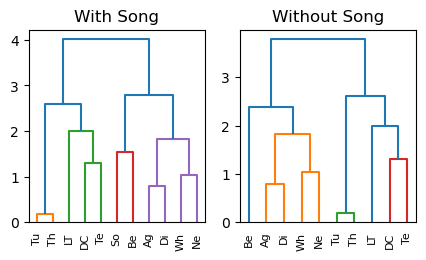

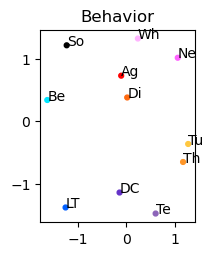

In [16]:
# Generage a distance based on logOR
confMatDist = np.zeros((nc,nc))
            
# Generate distances
confMatDist = -confMatTot
minval = np.min(np.diag(confMatDist))
confMatdist = confMatDist - minval

# Make it symmetric
for ic1 in range(nc):
    for ic2 in range (ic1, nc):
        if ic2 == ic1:
            confMatDist[ic1, ic2] = 0.0
        else:
            confMatDist[ic1, ic2] = (confMatDist[ic1, ic2] + confMatDist[ic2, ic1])/2
            confMatDist[ic2, ic1] = confMatDist[ic1, ic2]
                            
        
    
# Hieararchical clustering
clustered=linkage(squareform(confMatDist), method= 'ward' )# this works now
cophen_dist = cophenet(clustered)
plt.figure(figsize= (5,2.5), dpi=100)
plt.subplot(1,2,1)
D = dendrogram(Z=clustered, 
             color_threshold = 0.5*max(clustered[:,2]),
             leaf_rotation=90.,
             leaf_font_size=8,
             labels=callList)
plt.title('With Song')

clustered=linkage(squareform(confMatDist[1:,1:]), method= 'ward' )# this works now
cophen_dist = cophenet(clustered)
plt.subplot(1,2,2)
D = dendrogram(Z=clustered, 
             color_threshold = 0.5*max(clustered[:,2]),
             leaf_rotation=90.,
             leaf_font_size=8,
             labels=callList[1:])
plt.title('Without Song')

plt.savefig(figDir + 'BehaviorDendogram.eps')




# print(f'Cophen Distance {cophen_dist}')

# Multidimensional scaling
mdsDim = 2   # This is only specificied here
mds = MDS(dissimilarity='precomputed', random_state=0, n_components=mdsDim, n_init=10)
# Get the embeddings
behMDS = mds.fit_transform(confMatDist)
plt.figure(figsize= (2,2.5), dpi=100)
plt.scatter(behMDS[:,0], behMDS[:,1], s =12, c=[callColor[c] for c in callList] )
ax = plt.gca()
for i, txt in enumerate(callList):
    ax.annotate(txt, (behMDS[i,0], behMDS[i,1]))
plt.title('Behavior')
plt.savefig(figDir + f'BehaviorMDS{mdsDim}.eps')

In [ ]:
# Now the acoustic analysis

# The data directory
soundAnalysisDir = '../data/acoustic/' 

matAcoustic = scipy.io.loadmat(soundAnalysisDir+'vocTypePAFBird.mat')

# The matlab data is a structure with variable name PCC_Acoust (see postAnalCallsJulie.m)
# dataAcoustic = matAcoustic['PCC_Acoust']
dataAcoustic = matAcoustic['PCC_Acoust_perbird']

# For the confusion matrix it is the 5th elemenent for DFA and the 10th for RF
confMatCountAcoustic = dataAcoustic[0,0][10]

# This is the order of calls using the same variable name as in postAnalCallsJulie.m
name_grp = ['Ag', 'DC', 'Ne', 'Te', 'Wh', 'Di', 'So', 'Th', 'Tu', 'Be', 'LT']
name_grp_plot = ['Be', 'LT', 'Tu', 'Th', 'Di', 'Ag', 'Wh', 'Ne', 'Te', 'DC', 'So']

# This is the order of calls used in the behavioral analysis
callList = [ "So", "DC", "LT", "Te", "Tu", "Th", 'Ag', 'Di', "Wh", "Ne", "Be"]


nc = len(callList)
indINname_grp = []
for i in range(nc):
    indINname_grp.append(name_grp.index(callList[i]))




0.608151548584723


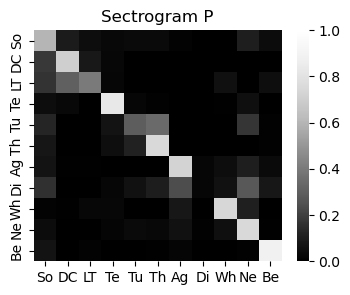

In [47]:
# Sum of all counts
confMatCountAcousticAll = np.sum(confMatCountAcoustic, axis=0)

# Generate a confusion matrix of probabilities.
confMatAcoustic = np.zeros((nc, nc))
for ir in range(nc):
    ntested = np.sum(confMatCountAcousticAll[ir,:])
    confMatAcoustic[ir,:] = confMatCountAcousticAll[ir,:]/ntested
    
# Plot that matrix to compare to matlab and figure paper
confMatAcousticdf = pd.DataFrame(confMatAcoustic, index=name_grp, columns=name_grp)


plt.figure(figsize= (4,3), dpi=100)
# sns.heatmap(confMatAcousticdf[name_grp_plot].reindex(name_grp_plot), vmin = 0, vmax = 1, cmap = 'Greys_r', annot=False)
sns.heatmap(confMatAcousticdf[callList].reindex(callList), vmin = 0, vmax = 1, cmap = 'Greys_r', annot=False)
plt.title('Sectrogram P')
plt.savefig(figDir + 'AcousticPAF_ConfMatProb.eps')
print(np.mean(np.diag(confMatAcousticdf)))


In [19]:
# Make a new confMatAcoustic where zero counts becomes 0.5 counts.

confMatCountAcousticF = np.array(confMatCountAcousticAll, dtype='float')

for ir in range(nc):
    for ic in range(nc):
        if confMatCountAcousticF[ir,ic] == 0.0 :
            confMatCountAcousticF[ir,ic] = 0.5 

for ir in range(nc):            
    ntested = np.sum(confMatCountAcousticF[ir,:])
    confMatAcoustic[ir,:] = confMatCountAcousticF[ir,:]/ntested

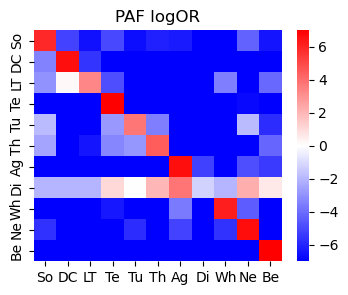

In [46]:
# Now generate a log OR confusion matrix.

confMatAcoustLOR = np.zeros((nc, nc))

for ic1 in range(nc):
    for ic2 in range(nc):
        if ic1 == ic2 :
            oddsReWrong = (1-confMatAcoustic[ic1, ic2])/confMatAcoustic[ic1, ic2]            
            pNoReWrong = (np.sum(confMatAcoustic[ic1, :])- confMatAcoustic[ic1, ic2])/(nc-1)                                                                               
            oddsNoReRight = (1-pNoReWrong)/pNoReWrong
            confMatAcoustLOR[ic1, ic2] = np.log2(oddsReWrong/oddsNoReRight)
        else:
            oddsNoReRight = (1-confMatAcoustic[ic1, ic2])/confMatAcoustic[ic1, ic2]
            oddsReWrong = (1-confMatAcoustic[ic1, ic1])/confMatAcoustic[ic1, ic1]
            confMatAcoustLOR[ic1, ic2] = np.log2(oddsNoReRight/oddsReWrong)
        
            

confMatAcoustLORdf = pd.DataFrame(confMatAcoustLOR, index=name_grp, columns=name_grp)


plt.figure(figsize= (4,3), dpi=100)

sns.heatmap(-confMatAcoustLORdf[callList].reindex(callList), vmin = -7, vmax = 7, annot=False, cmap = cmap)
plt.title('PAF logOR')
plt.savefig(figDir + '/AcousticPAF_ConfMatOR.eps')
plt.show()

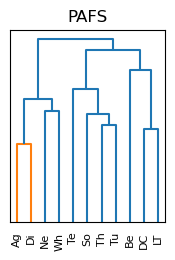

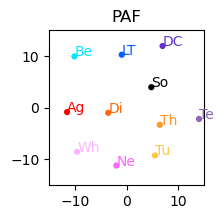

In [49]:
# Generage a distance based on logOR

confMatDistAcoust = np.zeros((nc,nc))

minval = np.min(np.diag(confMatAcoustLOR))
confMatDistAcoust = confMatAcoustLOR - minval

for ic1 in range(nc):
    for ic2 in range (ic1, nc):
        if ic1 == ic2:
            confMatDistAcoust[ic2, ic1] = 0
        else:    
            confMatDistAcoust[ic1, ic2] = (confMatDistAcoust[ic1, ic2] + confMatDistAcoust[ic2, ic1])/2
            confMatDistAcoust[ic2, ic1] = confMatDistAcoust[ic1, ic2]

            
                                  
# Hieararchical clustering
clustered=linkage(squareform(confMatDistAcoust), method= 'ward') # this works now
cophen_dist = cophenet(clustered)
plt.figure(figsize= (2,2.5), dpi=100)
D = dendrogram(Z=clustered, 
             color_threshold = 0.5*max(clustered[:,2]),
             leaf_rotation=90.,
             leaf_font_size=8,
             labels=name_grp)
plt.yticks([])
plt.title('PAFS')
plt.savefig(figDir + 'AcousticPAFDendogram.eps')

# Multidimensional scaling 
# Note that direction 0 is flipped so that it lines up better with UMAP
mdsDim = 2
mds = MDS(dissimilarity='precomputed', random_state=0, n_components=mdsDim, n_init=10)
# Get the embeddings
acMDS = mds.fit_transform(confMatDistAcoust)
plt.figure(figsize= (2,2.5), dpi=100)
plt.scatter(-acMDS[:,0], acMDS[:,1], s =12, c=[callColor[c] for c in name_grp] )
plt.axis('square')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xticks([-10, 0, 10])
plt.yticks([-10, 0, 10])
ax = plt.gca()
for i, txt in enumerate(name_grp):
    ax.annotate(txt, (-acMDS[i,0], acMDS[i,1]), color = callColor[txt])
plt.title('PAF')
plt.savefig( figDir + f'AcousticPAFMDS{mdsDim}.eps')

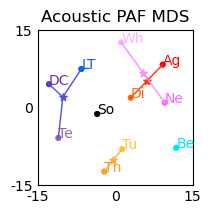

In [23]:
# Repeat MDS plot with ellipses
# Find the centroids and variances of semantic clusters. This code only works for 2d.
semCluster = {'Contact': ['LT', 'DC', 'Te'],  
              'Alarm': ['Tu', 'Th'], 
              'Fight' : ['Di', 'Ag'], 
              'Bond': ['Wh', 'Ne'], 
              'Display': ['So'],
              'Hunger' : ['Be']}

    
# Make Space
nCl = len(semCluster.keys())
ClusterColor = {}
ClusterAcCentroids = np.zeros((nCl,2))
ClusterAcStd = np.zeros((nCl,3))

# Calculate the mean centroid
for isem, sem in enumerate(semCluster.keys()):
    meanAc = np.zeros(2) 
    colorVal = np.zeros(3)
    for call in semCluster[sem]:
        icall = name_grp.index(call)
        meanAc += acMDS[icall,:2]
        colorVal += callColor[call]
        
        
    ClusterAcCentroids[isem,:] = meanAc/len(semCluster[sem])
    ClusterColor[sem] = colorVal/len(semCluster[sem])
    
# Calculate the variance of the semantic groups

for isem, sem in enumerate(semCluster.keys()):
    varAc = np.zeros(2)
    covAc = 0
    for call in semCluster[sem]:
        icall = name_grp.index(call)
        varAc += (acMDS[icall,:2]-ClusterAcCentroids[isem,:2])**2
        covAc += -(acMDS[icall,0]-ClusterAcCentroids[isem,0])*(acMDS[icall,1]-ClusterAcCentroids[isem,1])
    
    nc_in_sem = len(semCluster[sem])
    minSd = (np.std(ClusterAcCentroids))/(2.5*np.sqrt(nc))  
    if  nc_in_sem > 1:  
        ClusterAcStd[isem,:2] = np.sqrt(varAc/(nc_in_sem-1))
        ClusterAcStd[isem,2] = (covAc/nc_in_sem)/(ClusterAcStd[isem,0]*ClusterAcStd[isem,1])
        for i in range(2):
            if ClusterAcStd[isem,i] < minSd :
                ClusterAcStd[isem,i] = minSd
    else:
        ClusterAcStd[isem,:2] = minSd
            

plt.figure(figsize= (2,2.5), dpi=100)
ax = plt.gca()
ax.scatter(-acMDS[:,0], acMDS[:,1], s =12, c=[callColor[c] for c in name_grp] )
for i, txt in enumerate(name_grp):
    ax.annotate(txt, (-acMDS[i,0], acMDS[i,1]), color = callColor[txt])

if 0:
    for isem, sem in enumerate(semCluster.keys()):
        ell_radius_x = np.sqrt(1 + ClusterAcStd[isem,2])
        ell_radius_y = np.sqrt(1 - ClusterAcStd[isem,2])
        ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=ClusterColor[sem], alpha = 0.3)

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(ClusterAcStd[isem,0]*2, ClusterAcStd[isem,1]*2) \
            .translate(-ClusterAcCentroids[isem,0], ClusterAcCentroids[isem,1])

        ellipse.set_transform(transf + ax.transData)
        ax.add_patch(ellipse)

if 1:
    for isem, sem in enumerate(semCluster.keys()):
        if (len(semCluster[sem]) > 1):
            ax.scatter(-ClusterAcCentroids[isem,0], ClusterAcCentroids[isem,1], s =30, c=ClusterColor[sem], marker='*' )
            for call in semCluster[sem]:
                icall = name_grp.index(call)
                ax.plot([-acMDS[icall,0], -ClusterAcCentroids[isem,0]], [acMDS[icall,1], ClusterAcCentroids[isem,1]], linewidth=1, c= ClusterColor[sem])
    

ax.axis('square')
ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
ax.set_xticks([-15,0,15], labels=['-15','0','15'], color='k')
ax.set_yticks([-15,0,15], labels=['-15','0','15'], color='k')
ax.tick_params(direction='out', width=1, colors='k', length=0.2)
plt.title(f'Acoustic PAF MDS')


#plt.savefig(figDir + f'AcousticPAFMDS{mdsDim}SemOvals.eps')
plt.savefig(figDir + f'AcousticPAFMDS{mdsDim}wCentroids.eps')


In [28]:
# Perform the procrustes rotation to line up the two spaces

behMDSX, acMDSX, Mac = procrustes(behMDS, acMDS[indINname_grp, :])
# acMDSX, behMDSX, Mac = procrustes(acMDS[indINname_grp, :], behMDS)

Procustes disparity for 2d = 0.0679


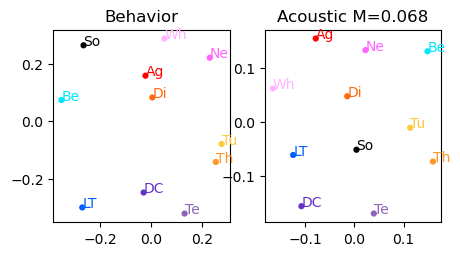

In [29]:
plt.figure(figsize= (5,2.5), dpi=100)

plt.subplot(1,2,1)
plt.scatter(behMDSX[:,0], behMDSX[:,1], s =12, c=[callColor[c] for c in callList] )
ax = plt.gca()
for i, txt in enumerate(callList):
    ax.annotate(txt, (behMDSX[i,0], behMDSX[i,1]), color = callColor[txt])
plt.title('Behavior')

plt.subplot(1,2,2)
plt.scatter(acMDSX[:,0], acMDSX[:,1], s =12, c=[callColor[c] for c in callList] )
ax = plt.gca()
for i, txt in enumerate(callList):
    ax.annotate(txt, (acMDSX[i,0], acMDSX[i,1]), color = callColor[txt])
plt.title(f'Acoustic M={Mac/len(callList):.3f}')

plt.savefig(figDir + f'BehaviorAcousticPAFMDS{mdsDim}.eps')
print(f'Procustes disparity for {mdsDim}d = {Mac/len(callList):.4f}')

In [30]:
def clusterCalc(Cluster, acMDSX, behMDSX):  
    # Calculates centroids, correlation matrix and color for clusters of calls defined in the
    # Cluster dictionary.
    
    # Make Space for returns
    nCl = len(Cluster.keys())
    ClusterColor = {}
    ClusterAcCentroids = np.zeros((nCl,2))
    ClusterBehCentroids = np.zeros((nCl,2))
    ClusterAcStd = np.zeros((nCl,3))
    ClusterBehStd = np.zeros((nCl,3))

    # Calculate the mean centroid
    for isem, sem in enumerate(Cluster.keys()):
        meanAc = np.zeros(2) 
        meanBeh = np.zeros(2)
        colorVal = np.zeros(3)
        for call in Cluster[sem]:
            icall = callList.index(call)
            meanAc += acMDSX[icall,:2]
            meanBeh += behMDSX[icall,:2]
            colorVal += callColor[call]
        
        
        ClusterAcCentroids[isem,:] = meanAc/len(Cluster[sem])
        ClusterBehCentroids[isem,:] = meanBeh/len(Cluster[sem])
        ClusterColor[sem] = colorVal/len(Cluster[sem])
    
    # Calculate the variance of the semantic groups

    for isem, sem in enumerate(Cluster.keys()):
        varAc = np.zeros(2)
        covAc = 0
        varBeh = np.zeros(2)
        covBeh = 0
        for call in Cluster[sem]:
            icall = callList.index(call)
            varAc += (acMDSX[icall,:2]-ClusterAcCentroids[isem,:2])**2
            varBeh += (behMDSX[icall,:2]-ClusterBehCentroids[isem,:2])**2
            covAc += (acMDSX[icall,0]-ClusterAcCentroids[isem,0])*(acMDSX[icall,1]-ClusterAcCentroids[isem,1])
            covBeh += (behMDSX[icall,0]-ClusterBehCentroids[isem,0])*(behMDSX[icall,1]-ClusterBehCentroids[isem,1])
        nc_in_sem = len(Cluster[sem])
        minSd = (np.std(ClusterAcCentroids)+np.std(ClusterBehCentroids))/(5*np.sqrt(nc))  # 5 = number of groups
        if  nc_in_sem > 1:  
            ClusterAcStd[isem,:2] = np.sqrt(varAc/(nc_in_sem-1))
            ClusterBehStd[isem,:2] = np.sqrt(varBeh/(nc_in_sem-1))
            ClusterAcStd[isem,2] = (covAc/nc_in_sem)/(ClusterAcStd[isem,0]*ClusterAcStd[isem,1])
            ClusterBehStd[isem,2] = (covBeh/nc_in_sem)/(ClusterBehStd[isem,0]*ClusterBehStd[isem,1])
            for i in range(2):
                if ClusterAcStd[isem,i] < minSd :
                    ClusterAcStd[isem,i] = minSd
                if ClusterBehStd[isem,i] < minSd :
                    ClusterBehStd[isem,i] = minSd

        else:
            ClusterAcStd[isem,:2] = minSd
            ClusterBehStd[isem,:2] = minSd
            ClusterAcStd[isem,2] = 0
            ClusterBehStd[isem,2] = 0
            
    return   ClusterColor, ClusterAcCentroids, ClusterBehCentroids, ClusterAcStd, ClusterBehStd      
        
    

In [31]:
# Find the centroids and variances of semantic clusters. This code only works for 2d.
semCluster = {'Contact': ['LT', 'DC', 'Te'],  
              'Alarm': ['Tu', 'Th'], 
              'Fight' : ['Di', 'Ag'], 
              'Bond': ['Wh', 'Ne'], 
              'Display': ['So'],
              'Hunger' : ['Be']}

semClusterColor, semClusterAcCentroids, semClusterBehCentroids, semClusterAcStd, semClusterBehStd = clusterCalc(semCluster, acMDSX, behMDSX)

Procustes disparity for 2d = 0.0679


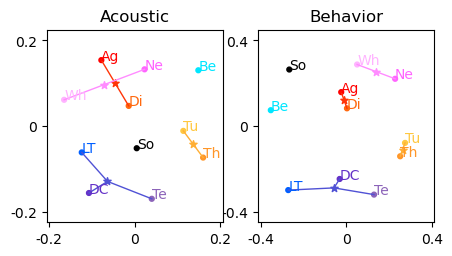

In [35]:
# Draw previous diagram with semantic groups

plt.figure(figsize= (5,2.5), dpi=100)
ax1 = plt.subplot(1,2,2)

ax1.scatter(behMDSX[:,0], behMDSX[:,1], s =12, c=[callColor[c] for c in callList] )

for i, txt in enumerate(callList):
    ax1.annotate(txt, (behMDSX[i,0], behMDSX[i,1]), color = callColor[txt])

if 0:
    for isem, sem in enumerate(semCluster.keys()):
        ell_radius_x = np.sqrt(1 + semClusterBehStd[isem,2])
        ell_radius_y = np.sqrt(1 - semClusterBehStd[isem,2])
        ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=semClusterColor[sem], alpha = 0.3)

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(semClusterBehStd[isem,0]*2, semClusterBehStd[isem,1]*2) \
            .translate(semClusterBehCentroids[isem,0], semClusterBehCentroids[isem,1])

        ellipse.set_transform(transf + ax1.transData)
        ax1.add_patch(ellipse)

if 1:
    for isem, sem in enumerate(semCluster.keys()):
        if (len(semCluster[sem]) > 1):
            ax1.scatter(semClusterBehCentroids[isem,0], semClusterBehCentroids[isem,1], s =30, c=semClusterColor[sem], marker='*' )
            for call in semCluster[sem]:
                icall = callList.index(call)
                ax1.plot([behMDSX[icall,0], semClusterBehCentroids[isem,0]], [behMDSX[icall,1], semClusterBehCentroids[isem,1]], linewidth=1, c= ClusterColor[sem])

ax1.axis('equal')   
ax1.set_xlim((-0.45, 0.45))
ax1.set_ylim((-0.45, 0.45))
ax1.set_xticks([-0.4, 0, 0.4], labels = ['-0.4', '0', '0.4'])
ax1.set_yticks([-0.4, 0, 0.4], labels = ['-0.4', '0', '0.4'])


plt.title('Behavior')

ax2 = plt.subplot(1,2,1)
ax2.scatter(acMDSX[:,0], acMDSX[:,1], s =12, c=[callColor[c] for c in callList] )
for i, txt in enumerate(callList):
    ax2.annotate(txt, (acMDSX[i,0], acMDSX[i,1]), color = callColor[txt])

if 0:
    for isem, sem in enumerate(semCluster.keys()):
        ell_radius_x = np.sqrt(1 + semClusterAcStd[isem,2])
        ell_radius_y = np.sqrt(1 - semClusterAcStd[isem,2])
        ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=semClusterColor[sem], alpha = 0.3)

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(semClusterAcStd[isem,0]*2, semClusterAcStd[isem,1]*2) \
            .translate(semClusterAcCentroids[isem,0], semClusterAcCentroids[isem,1])

        ellipse.set_transform(transf + ax2.transData)
        ax2.add_patch(ellipse)

if 1:
    for isem, sem in enumerate(semCluster.keys()):
        if (len(semCluster[sem]) > 1):
            ax2.scatter(semClusterAcCentroids[isem,0], semClusterAcCentroids[isem,1], s =30, c=semClusterColor[sem], marker='*' )
            for call in semCluster[sem]:
                icall = callList.index(call)
                ax2.plot([acMDSX[icall,0], semClusterAcCentroids[isem,0]], [acMDSX[icall,1], semClusterAcCentroids[isem,1]], linewidth=1, c= ClusterColor[sem])

ax2.axis('equal')
ax2.set_xlim((-0.225, 0.225))
ax2.set_ylim((-0.225, 0.225))
ax2.set_xticks([-0.2, 0, 0.2], labels = ['-0.2', '0', '0.2'])
ax2.set_yticks([-0.2, 0, 0.2], labels = ['-0.2', '0', '0.2'])



    
plt.title(f'Acoustic')

plt.savefig(figDir + f'BehaviorAcousticPAFMDS{mdsDim}Grouped.eps')
print(f'Procustes disparity for {mdsDim}d = {Mac/len(callList):.4f}')

In [36]:
# Calculate within and between distances

def calcDistCluster(Cluster,  ClusterAcCentroids, ClusterBehCentroids, acMDSX, behMDSX):
# Calculates the within and between centroids. 
    nCl = len(Cluster.keys())
    ClusterAcDistWithin = np.zeros(nCl)
    ClusterAcDistAcross = np.zeros(nCl)
    ClusterBehDistWithin = np.zeros(nCl)
    ClusterBehDistAcross = np.zeros(nCl)

    # Find all calls in Cluster
    callListCluster = []
    for sem in semCluster.keys():
        for calls in semCluster[sem]:
            callListCluster.append(calls)

    # Calculate the distances to centroids for within groups and across groups
    for isem, sem in enumerate(Cluster.keys()):
        nWithin = 0
        nAcross = 0
        for icall, call in enumerate(callList):
            if call in callListCluster:
                if call in Cluster[sem]:
                    nWithin += 1
                    ClusterAcDistWithin[isem] += np.sum((acMDSX[icall,:2]-ClusterAcCentroids[isem,:2])**2)
                    ClusterBehDistWithin[isem] += np.sum((behMDSX[icall,:2]-ClusterBehCentroids[isem,:2])**2)
                else:
                    nAcross += 1
                    ClusterAcDistAcross[isem] += np.sum((acMDSX[icall,:2]-ClusterAcCentroids[isem,:2])**2)
                    ClusterBehDistAcross[isem] += np.sum((behMDSX[icall,:2]-ClusterBehCentroids[isem,:2])**2)
    
        ClusterAcDistWithin[isem] /= nWithin
        ClusterBehDistWithin[isem] /= nWithin
        ClusterAcDistAcross[isem] /= nAcross
        ClusterBehDistAcross[isem] /= nAcross
    
    #print(f'-----Semantic group {sem}----------')
    #print(f'nWithin = {nWithin}, nAcross = {nAcross}')
    #print(f'Acoustic: D within = {ClusterAcDistWithin[isem]:.3f} D across = {ClusterAcDistAcross[isem]:.3f} R = {ClusterAcDistAcross[isem]/ClusterAcDistWithin[isem]:.3f}' )
    #print(f'Behavior: D within = {ClusterBehDistWithin[isem]:.3f} D across = {ClusterBehDistAcross[isem]:.3f} R = {ClusterBehDistAcross[isem]/ClusterBehDistWithin[isem]:.3f}')

    # Average distances
    acDistWithin = np.mean(ClusterAcDistWithin)
    acDistAcross = np.mean(ClusterAcDistAcross)
    behDistWithin = np.mean(ClusterBehDistWithin)
    behDistAcross = np.mean(ClusterBehDistAcross)
    
    return acDistWithin, acDistAcross, behDistWithin, behDistAcross


In [37]:
acDistWithin, acDistAcross, behDistWithin, behDistAcross = calcDistCluster(semCluster,  
                                                                           semClusterAcCentroids, 
                                                                           semClusterBehCentroids, 
                                                                           acMDSX, behMDSX)

print(f'----- Average ----------')

print(f'Acoustic: D within = {acDistWithin:.3f} D across = {acDistAcross:.3f} Q = {acDistAcross/acDistWithin:.3f}' )
print(f'Behavior: D within = {behDistWithin:.3f} D across = {behDistAcross:.3f} Q = {behDistAcross/behDistWithin:.3f}')


----- Average ----------
Acoustic: D within = 0.004 D across = 0.049 Q = 12.587
Behavior: D within = 0.007 D across = 0.214 Q = 32.196


In [38]:
# Find the centroids and variances of semantic clusters. This code only works for 2d.
semClusterNoSo = {'Contact': ['LT', 'DC', 'Te'],  
              'Alarm': ['Tu', 'Th'], 
              'Fight' : ['Di', 'Ag'], 
              'Bond': ['Wh', 'Ne'], 
              'Hunger' : ['Be']}


callListNoSo = []
for sem in semClusterNoSo.keys():
    for calls in semCluster[sem]:
        callListNoSo.append(calls)


semClusterNoSoColor, semClusterNoSoAcCentroids, semClusterNoSoBehCentroids, semClusterNoSoAcStd, semClusterNoSoBehStd = clusterCalc(semClusterNoSo, acMDSX, behMDSX)

acDistWithin, acDistAcross, behDistWithin, behDistAcross = calcDistCluster(semClusterNoSo,  
                                                                           semClusterAcCentroids, 
                                                                           semClusterBehCentroids,
                                                                           acMDSX, behMDSX)

print(f'----- Average No Song ----------')

print(f'Acoustic: D within = {acDistWithin:.3f} D across = {acDistAcross:.3f} Q = {acDistAcross/acDistWithin:.3f}' )
print(f'Behavior: D within = {behDistWithin:.3f} D across = {behDistAcross:.3f} Q = {behDistAcross/behDistWithin:.3f}')

----- Average No Song ----------
Acoustic: D within = 0.015 D across = 0.044 Q = 2.833
Behavior: D within = 0.017 D across = 0.207 Q = 12.408


In [42]:
# Generate distributions of random groups 1 of size 3, 3 of size 2 and 2 of size 1.

nc = len(callList)
nperm = 1000

randAcWithin = np.zeros(nperm)
randAcAcross = np.zeros(nperm)
randBehWithin = np.zeros(nperm)
randBehAcross = np.zeros(nperm)


for iperm in range(nperm):
    # Generate a ramdom permunation.
    indRand = np.random.permutation(nc)
    
    randCluster = {'G3': [callList[i] for i in indRand[0:3]],  
              'G2A': [callList[i] for i in indRand[3:5]], 
              'G2B' : [callList[i] for i in indRand[5:7]], 
              'G2C': [callList[i] for i in indRand[7:9]], 
              'G1A': [callList[indRand[9]]],
              'G1B' : [callList[indRand[10]]]}
    
    # Calculate centroids of random groups
    randClusterColor, randClusterAcCentroids, randClusterBehCentroids, randClusterAcStd, randClusterBehStd = clusterCalc(randCluster, acMDSX, behMDSX)
    
    randAcWithin[iperm], randAcAcross[iperm], randBehWithin[iperm], randBehAcross[iperm] = calcDistCluster(randCluster,  
                                                                           randClusterAcCentroids, 
                                                                           randClusterBehCentroids,
                                                                           acMDSX, behMDSX)
   
    

    
print(f'Acoustic: D within = {randAcWithin[iperm]:.3f} D across = {randAcAcross[iperm]:.3f} Q = {randAcAcross[iperm]/randAcWithin[iperm]:.3f}' )
print(f'Behavior: D within = {randBehWithin[iperm]:.3f} D across = {randBehAcross[iperm]:.3f} Q = {randBehAcross[iperm]/randBehWithin[iperm]:.3f}')


Acoustic: D within = 0.004 D across = 0.051 Q = 12.377
Behavior: D within = 0.023 D across = 0.174 Q = 7.428


In [40]:
# Perform a double boot strap analysis with nested permutation.

NBOOT = 1000
nperm = 1000
mdsDim = 2   
nbirdsBeh = len(resultsBird['Bird'])
nbirdsAc = confMatCountAcoustic.shape[0]
behQBoot = np.zeros(NBOOT)
behQBootNoSo = np.zeros(NBOOT)
behCountBoot = np.zeros(NBOOT)
behCountBootNoSo = np.zeros(NBOOT)
acQBoot = np.zeros(NBOOT)
acQBootNoSo = np.zeros(NBOOT)
acCountBoot = np.zeros(NBOOT)
acCountBootNoSo = np.zeros(NBOOT)
acPCCBoot = np.zeros(NBOOT)
macBoot = np.zeros(NBOOT)
macCountBoot = np.zeros(NBOOT)
behRandQBoot = np.zeros(NBOOT*nperm)
acRandQBoot = np.zeros(NBOOT*nperm)
behRandQBootNoSo = np.zeros(NBOOT*nperm)
acRandQBootNoSo = np.zeros(NBOOT*nperm)
macRandBoot = np.zeros(NBOOT*nperm)

behMDSXBootAll = np.zeros((behMDS.shape[0], NBOOT, behMDS.shape[1]))
acMDSXBootAll = np.zeros((behMDS.shape[0], NBOOT, behMDS.shape[1]))
macPerm = np.zeros(nperm)

# For replication 
np.random.seed(123)

for iboot in range(NBOOT):
    
    # Sampling with replacement first for behavior
    indboot = np.random.choice(range(nbirdsBeh), size=nbirdsBeh, replace=True)
    resultsBoot = [resultsBird['Results'][i] for i in indboot]

    # Create total confusion matrix for this bootstrapped sample
    resultsTot = {}
    for ct in callList:
        resultsTot[ct] = {}
        for ct2 in callList2: 
            resultsTot[ct][ct2] = np.array([0, 0, 0])

    for results in resultsBoot:
        for ct in callList:
            for ct2 in callList2: 
                resultsTot[ct][ct2] += np.array(results[ct][ct2])

    confMatTot = results_to_confusion(resultsTot, mode='logOR')

    # From the confusion matrix to the distance matrix
    # confMatDist = np.zeros((nc,nc))
    # for ic1 in range(nc):
    #     for ic2 in range (nc):
    #         confMatDist[ic1, ic2] = -confMatTot[ic1,ic2]
    #         if ic1 == ic2 :
    #             confMatDist[ic1, ic2] = 0
    #         else:
    #             confMatDist[ic1, ic2] = -confMatTot[ic1,ic2]

    # for ic1 in range(nc):
    #     for ic2 in range (ic1, nc):
    #         confMatDist[ic1, ic2] = (confMatDist[ic1, ic2] + confMatDist[ic2, ic1])/2
    #         confMatDist[ic2, ic1] = confMatDist[ic1, ic2]
    # Generate distances
    confMatDist = -confMatTot
    minval = np.min(np.diag(confMatDist))
    confMatdist = confMatDist - minval

    # Make it symmetric
    for ic1 in range(nc):
        for ic2 in range (ic1, nc):
            if ic2 == ic1:
                confMatDist[ic1, ic2] = 0.0
            else:
                confMatDist[ic1, ic2] = (confMatDist[ic1, ic2] + confMatDist[ic2, ic1])/2
                confMatDist[ic2, ic1] = confMatDist[ic1, ic2]

    # Sampling with replacement for acoustic analysis
    indboot = np.random.choice(range(nbirdsAc), size=nbirdsAc, replace=True)
    confMatCountAcousticAll = np.zeros((nc,nc))
    for i in indboot:
        confMatCountAcousticAll += confMatCountAcoustic[i,:,:]

    # Generate a confMatAcoustic based on probabilities.

    confMatAcousticP = np.zeros((nc, nc))
    for ir in range(nc):
        ntested = np.sum(confMatCountAcousticAll[ir,:])
        confMatAcousticP[ir,:] = confMatCountAcousticAll[ir,:]/ntested
    
    acPCCBoot[iboot] = np.mean(np.diag(confMatAcousticP))
    
    # Make a new confMatAcoustic based on logOR where zero counts becomes 0.5 counts.
    confMatCountAcousticF = np.array(confMatCountAcousticAll, dtype='float')
    for ir in range(nc):
        for ic in range(nc):
            if confMatCountAcousticF[ir,ic] == 0.0 :
                confMatCountAcousticF[ir,ic] = 0.5 
    for ir in range(nc):            
        ntested = np.sum(confMatCountAcousticF[ir,:])
        confMatAcoustic[ir,:] = confMatCountAcousticF[ir,:]/ntested
    
    confMatAcoustLOR = np.zeros((nc, nc))
    for ic1 in range(nc):
        for ic2 in range(nc):
            if ic1 == ic2 :
                oddsReWrong = (1-confMatAcoustic[ic1, ic2])/confMatAcoustic[ic1, ic2]            
                pNoReWrong = (np.sum(confMatAcoustic[ic1, :])- confMatAcoustic[ic1, ic2])/(nc-1)                                                                               
                oddsNoReRight = (1-pNoReWrong)/pNoReWrong
                confMatAcoustLOR[ic1, ic2] = np.log2(oddsReWrong/oddsNoReRight)
            else:
                oddsNoReRight = (1-confMatAcoustic[ic1, ic2])/confMatAcoustic[ic1, ic2]
                oddsReWrong = (1-confMatAcoustic[ic1, ic1])/confMatAcoustic[ic1, ic1]
                confMatAcoustLOR[ic1, ic2] = np.log2(oddsNoReRight/oddsReWrong)

    

    confMatDistAcoust = np.zeros((nc,nc))

    minval = np.min(np.diag(confMatAcoustLOR))
    confMatDistAcoust = confMatAcoustLOR - minval

    for ic1 in range(nc):
        for ic2 in range (ic1, nc):
            if ic1 == ic2:
                confMatDistAcoust[ic2, ic1] = 0
            else:    
                confMatDistAcoust[ic1, ic2] = (confMatDistAcoust[ic1, ic2] + confMatDistAcoust[ic2, ic1])/2
                confMatDistAcoust[ic2, ic1] = confMatDistAcoust[ic1, ic2]    
    
    """     confMatDistAcoust = np.zeros((nc,nc))          
    for ic1 in range(nc):
        for ic2 in range (ic1, nc):
            confMatDistAcoust[ic1, ic2] = (confMatAcoustLOR[ic1, ic2] + confMatAcoustLOR[ic2, ic1])/2
            confMatDistAcoust[ic2, ic1] = confMatDistAcoust[ic1, ic2]
            if ic1 == ic2:
                confMatDistAcoust[ic2, ic1] = 0 """
            
    # Multidimensional scaling for acoustic and behavior
    mdsDim = 2
    mds = MDS(dissimilarity='precomputed', random_state=0, n_components=mdsDim, n_init=10)  
    acMDSBoot = mds.fit_transform(confMatDistAcoust)

    mds = MDS(dissimilarity='precomputed', random_state=0, n_components=mdsDim, n_init=10)
    behMDSBoot = mds.fit_transform(confMatDist)

    # Procrustes Rotations between bootstraps
    behMDSXB, acMDSXB, macBoot[iboot] = procrustes(behMDSBoot, acMDSBoot[indINname_grp, :])

    # Procrustes Rotation to Behavioral Reference for plotting old cloud of points or data always aligned similarly
    behMDSXRef, behMDSXBoot, Mac = procrustes(behMDS, behMDSBoot)
    behMDSXRef, acMDSXBoot, Mac = procrustes(behMDS, acMDSBoot[indINname_grp, :] )
    for ic in range(nc):
        behMDSXBootAll[ic,iboot,:] = behMDSXBoot[ic,:]   
        acMDSXBootAll[ic,iboot,:] = acMDSXBoot[ic,:]     


    # Distances to semantic hyperclusters uses behMDSX and acMDSx
    semClusterColor, semClusterAcCentroids, semClusterBehCentroids, semClusterAcStd, semClusterBehStd = clusterCalc(semCluster, acMDSXB, behMDSXB)
    acDistWithin, acDistAcross, behDistWithin, behDistAcross = calcDistCluster(semCluster,  
                                                                           semClusterAcCentroids, 
                                                                           semClusterBehCentroids,
                                                                           acMDSXB, behMDSXB)
    behQBoot[iboot] = behDistAcross/behDistWithin
    acQBoot[iboot] = acDistAcross/acDistWithin

    # Distances to semantic hyperclusters uses behMDSX and acMDSx excluding Song
    semClusterNoSoColor, semClusterNoSoAcCentroids, semClusterNoSoBehCentroids, semClusterNoSoAcStd, semClusterNoSoBehStd = clusterCalc(semClusterNoSo, acMDSXB, behMDSXB)
    acDistNoSoWithin, acDistNoSoAcross, behDistNoSoWithin, behDistNoSoAcross = calcDistCluster(semClusterNoSo,  
                                                                           semClusterNoSoAcCentroids, 
                                                                           semClusterNoSoBehCentroids,
                                                                           acMDSXB, behMDSXB)
    behQBootNoSo[iboot] = behDistNoSoAcross/behDistNoSoWithin
    acQBootNoSo[iboot] = acDistNoSoAcross/acDistNoSoWithin

    randAcWithin = np.zeros(nperm)
    randAcAcross = np.zeros(nperm)
    randBehWithin = np.zeros(nperm)
    randBehAcross = np.zeros(nperm)
    randAcWithinNoSo = np.zeros(nperm)
    randAcAcrossNoSo = np.zeros(nperm)
    randBehWithinNoSo = np.zeros(nperm)
    randBehAcrossNoSo = np.zeros(nperm)

    indSo = np.argwhere(np.array(callList) == 'So')[0][0]   # the indes of song in callList
    for iperm in range(nperm):
        # Generate a ramdom permunation.
        indRand = np.random.permutation(nc)
        indRandSo = np.argwhere(indRand == indSo)[0][0]
        indRandNoSo = np.delete(indRand, indRandSo)
        macPerm[iperm] = np.sum((behMDSXB-acMDSXB[indRand])**2)
    
        randCluster = {'G3': [callList[i] for i in indRand[0:3]],  
                'G2A': [callList[i] for i in indRand[3:5]], 
                'G2B' : [callList[i] for i in indRand[5:7]], 
                'G2C': [callList[i] for i in indRand[7:9]], 
                'G1A': [callList[indRand[9]]],
                'G1B' : [callList[indRand[10]]]}
        
        randClusterNoSo = {'G3': [callList[i] for i in indRandNoSo[0:3]],  
                'G2A': [callList[i] for i in indRandNoSo[3:5]], 
                'G2B' : [callList[i] for i in indRandNoSo[5:7]], 
                'G2C': [callList[i] for i in indRandNoSo[7:9]], 
                'G1': [callList[indRandNoSo[9]]]}
        

    
        # Calculate centroids of random groups
        randClusterColor, randClusterAcCentroids, randClusterBehCentroids, randClusterAcStd, randClusterBehStd = clusterCalc(randCluster,acMDSXB, behMDSXB)
    
        randAcWithin[iperm], randAcAcross[iperm], randBehWithin[iperm], randBehAcross[iperm] = calcDistCluster(randCluster,  
                                                                           randClusterAcCentroids, 
                                                                           randClusterBehCentroids,
                                                                           acMDSXB, behMDSXB)
        
        # Calculate centroids of random groups
        randClusterNoSoColor, randClusterNoSoAcCentroids, randClusterNoSoBehCentroids, randClusterNoSoAcStd, randClusterNoSoBehStd = clusterCalc(randClusterNoSo,acMDSXB, behMDSXB)
    
        randAcWithinNoSo[iperm], randAcAcrossNoSo[iperm], randBehWithinNoSo[iperm], randBehAcrossNoSo[iperm] = calcDistCluster(randClusterNoSo,  
                                                                           randClusterNoSoAcCentroids, 
                                                                           randClusterNoSoBehCentroids,
                                                                           acMDSXB, behMDSXB)


    behCountBoot[iboot] = np.sum((randBehAcross/randBehWithin) > behQBoot[iboot])
    acCountBoot[iboot] = np.sum((randAcAcross/randAcWithin) > acQBoot[iboot])
    
    behCountBootNoSo[iboot] = np.sum((randBehAcrossNoSo/randBehWithinNoSo) > behQBootNoSo[iboot])
    acCountBootNoSo[iboot] = np.sum((randAcAcrossNoSo/randAcWithinNoSo) > acQBootNoSo[iboot])

    macCountBoot[iboot] = np.sum(macPerm < macBoot[iboot])

    acRandQBoot[iboot*nperm:(iboot+1)*nperm] = randBehAcross/randBehWithin
    behRandQBoot[iboot*nperm:(iboot+1)*nperm] = randAcAcross/randAcWithin
    acRandQBootNoSo[iboot*nperm:(iboot+1)*nperm] = randBehAcrossNoSo/randBehWithinNoSo
    behRandQBootNoSo[iboot*nperm:(iboot+1)*nperm] = randAcAcrossNoSo/randAcWithinNoSo


    macRandBoot[iboot*nperm:(iboot+1)*nperm] = macPerm

       
    

In [41]:
print('Bootstrapped PCC for acoustic =  %.3f +- %.3f (2SE)' % (np.mean(acPCCBoot), 2*np.std(acPCCBoot)))

print('Mean Procrustes Disparity = %.3f +- %.3f (2SE)' % (np.mean(macBoot/nc), 2*np.std(macBoot/nc)))
print('Mean Permuted Procrustes Disparity =  %.3f +- %.3f (2SE)' % (np.mean(macRandBoot/nc), 2*np.std(macRandBoot/nc)))
print('Disparity Effect Size R2= %.3f' % (1-np.mean(macBoot)/np.mean(macRandBoot)) )
print("Percent times disparity is greater than chance: %.2f%% (%d/%d)" % ( 100.0*np.sum(macCountBoot)/(NBOOT*nperm), np.sum(macCountBoot), NBOOT*nperm))
     
print("Q Values")
print('WITH SONG')
print('Mean Behavior Between/Within Q = %.2f +- %.3f (2SE)' % (np.mean(behQBoot), 2*np.std(behQBoot)) )
print('Nested Permutation test: Mean p value %.4f' % (np.mean(behCountBoot)/nperm))

print('Mean Acoustic Between/Within Q = %.2f +- %.3f (2SE)' % (np.mean(acQBoot), 2*np.std(acQBoot)) )
print('Nested Permutation test: Mean p value %.4f' % (np.mean(acCountBoot)/nperm))

print("Percent times behavior is greater than acoustic: %.2f%% (%d/%d)" % ( 100.0*np.sum(behQBoot > acQBoot)/NBOOT, np.sum(behQBoot> acQBoot), NBOOT))

print('WITHOUT SONG')
print('Mean Behavior Between/Within Q = %.2f +- %.3f (2SE)' % (np.mean(behQBootNoSo), 2*np.std(behQBootNoSo)) )
print('Nested Permutation test: Mean p value %.4f' % (np.mean(behCountBootNoSo)/nperm))

print('Mean Acoustic Between/Within Q = %.2f +- %.3f (2SE)' % (np.mean(acQBootNoSo), 2*np.std(acQBootNoSo)) )
print('Nested Permutation test: Mean p value %.4f' % (np.mean(acCountBootNoSo)/nperm))

print("Percent times behavior is greater than acoustic: %.2f%% (%d/%d)" % ( 100.0*np.sum(behQBootNoSo > acQBootNoSo)/NBOOT, np.sum(behQBootNoSo> acQBootNoSo), NBOOT))



Bootstrapped PCC for acoustic =  0.609 +- 0.030 (2SE)
Mean Procrustes Disparity = 0.045 +- 0.035 (2SE)
Mean Permuted Procrustes Disparity =  0.137 +- 0.068 (2SE)
Disparity Effect Size R2= 0.673
Percent times disparity is greater than chance: 0.50% (4997/1000000)
Q Values
WITH SONG
Mean Behavior Between/Within Q = 26.73 +- 18.285 (2SE)
Nested Permutation test: Mean p value 0.0021
Mean Acoustic Between/Within Q = 12.69 +- 3.956 (2SE)
Nested Permutation test: Mean p value 0.0192
Percent times behavior is greater than acoustic: 96.40% (964/1000)
WITHOUT SONG
Mean Behavior Between/Within Q = 21.59 +- 15.360 (2SE)
Nested Permutation test: Mean p value 0.0023
Mean Acoustic Between/Within Q = 11.42 +- 3.578 (2SE)
Nested Permutation test: Mean p value 0.0104
Percent times behavior is greater than acoustic: 93.00% (930/1000)


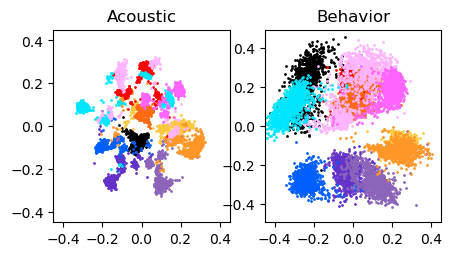

In [42]:
# This is the orignal panel of figure 4 showing all of the bootstraps
# Redo the procrustes rotation with all the data because we overwrote it in the bootstrap

# behMDSX, acMDSX, Mac = procrustes(behMDS, acMDS[indINname_grp, :])

# plot the new data as clouds.
plt.figure(figsize= (5,2.5), dpi=100)

plt.subplot(1,2,1)
# plt.scatter(acMDSX[:,0], acMDSX[:,1], s =12, c=[callColor[c] for c in callList] )
ax = plt.gca()
for i, txt in enumerate(callList):
    # ax.annotate(txt, (acMDSX[i,0], acMDSX[i,1]), color = callColor[txt])
    plt.scatter(acMDSXBootAll[i,:,0], acMDSXBootAll[i,:,1], color = callColor[txt], s=1)
    
plt.xlim((-0.45, 0.45))
plt.ylim((-0.45, 0.45))
plt.xticks([-0.4, -0.2, 0, 0.2, 0.4], visible=True)
plt.yticks([-0.4, -0.2, 0, 0.2, 0.4], visible=True)
plt.title('Acoustic')


plt.subplot(1,2,2)
# plt.scatter(behMDSX[:,0], behMDSX[:,1], s =12, c=[callColor[c] for c in callList] )
ax = plt.gca()
for i, txt in enumerate(callList):
    # ax.annotate(txt, (behMDSX[i,0], behMDSX[i,1]), color = callColor[txt])
    plt.scatter(behMDSXBootAll[i,:,0], behMDSXBootAll[i,:,1], color = callColor[txt], s=1)
    
plt.axis('equal')
plt.xlim((-0.45, 0.45))
plt.ylim((-0.45, 0.45))
plt.xticks([-0.4, -0.2, 0, 0.2, 0.4], visible=True)
plt.yticks([-0.4, -0.2, 0, 0.2, 0.4], visible=True)
plt.title('Behavior')



plt.savefig(figDir + 'BehaviorAcousticPAFMDSCloud.eps')

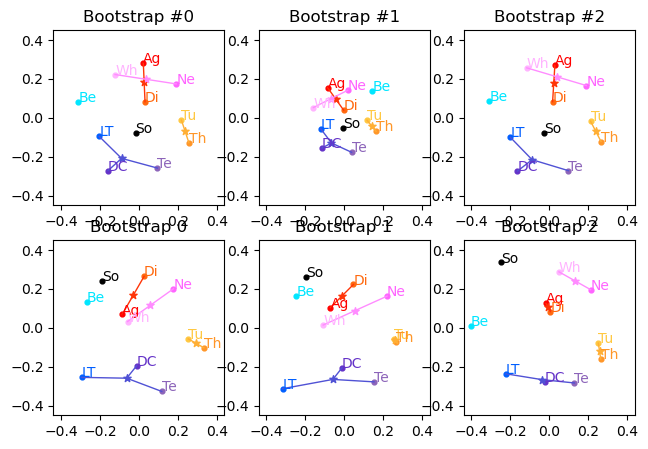

In [48]:
# This is the new panel of figure 4 showing three bootstraps
nexamples = 3

# Redo the procrustes rotation with all the data because we overwrote it in the bootstrap
# THis is also done on previous cell but can be repeated
# behMDSX, acMDSX, Mac = procrustes(behMDS, acMDS[indINname_grp, :])

# plot the new data as clouds.
plt.figure(figsize= (7.5,5), dpi=100)


for k in range(nexamples):

    semClusterColor, semClusterAcCentroids, semClusterBehCentroids, semClusterAcStd, semClusterBehStd = clusterCalc(semCluster, np.squeeze(acMDSXBootAll[:,k,:]), np.squeeze(behMDSXBootAll[:,k,:]))
    # Draw centroids
    ax1 = plt.subplot(2,nexamples,k+1)
    for i, txt in enumerate(callList):
        ax1.annotate(txt, (acMDSXBootAll[i, k, 0], acMDSXBootAll[i, k, 1]), color = callColor[txt])
        plt.scatter(acMDSXBootAll[i,k,0], acMDSXBootAll[i,k,1], color = callColor[txt], s=12)

    if 0:
        for isem, sem in enumerate(semCluster.keys()):
            ell_radius_x = np.sqrt(1 + semClusterAcStd[isem,2])
            ell_radius_y = np.sqrt(1 - semClusterAcStd[isem,2])
            ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=semClusterColor[sem], alpha = 0.3)

            transf = transforms.Affine2D() \
                .rotate_deg(45) \
                .scale(semClusterAcStd[isem,0]*2, semClusterAcStd[isem,1]*2) \
                .translate(semClusterAcCentroids[isem,0], semClusterAcCentroids[isem,1])

            ellipse.set_transform(transf + ax1.transData)
            ax1.add_patch(ellipse)
    
        # Draw lines between call types within hyper categories
        for isem, sem in enumerate(semCluster.keys()):
                for i, txti in enumerate(callList):
                    if txti in semCluster[sem]:
                        for j, txtj in enumerate(callList):
                           if ( (txtj in semCluster[sem]) & (j!= i) ):
                                plt.plot([acMDSXBootAll[i,k,0], acMDSXBootAll[j,k,0]], [acMDSXBootAll[i,k,1], acMDSXBootAll[j,k,1]], '-', color = semClusterColor[sem], linewidth=2)

    if 1:
        for isem, sem in enumerate(semCluster.keys()):
            if (len(semCluster[sem]) > 1):
                ax1.scatter(semClusterAcCentroids[isem,0], semClusterAcCentroids[isem,1], s =30, c=semClusterColor[sem], marker='*' )
                for call in semCluster[sem]:
                    icall = callList.index(call)
                    ax1.plot([acMDSXBootAll[icall,k,0], semClusterAcCentroids[isem,0]], [acMDSXBootAll[icall,k,1], semClusterAcCentroids[isem,1]], linewidth=1, c= semClusterColor[sem])
    
    plt.axis('equal')
    plt.xlim((-0.45, 0.45))
    plt.ylim((-0.45, 0.45))
    plt.xticks([-0.4, -0.2, 0, 0.2, 0.4], visible=True)
    plt.yticks([-0.4, -0.2, 0, 0.2, 0.4], visible=True)
    plt.title('Bootstrap #%d'%(k))

    # Draw centroids
    ax2 = plt.subplot(2,nexamples,nexamples+k+1)
    for i, txt in enumerate(callList):
        ax2.annotate(txt, (behMDSXBootAll[i, k, 0], behMDSXBootAll[i, k, 1]), color = callColor[txt])
        plt.scatter(behMDSXBootAll[i,k,0], behMDSXBootAll[i,k,1], color = callColor[txt], s=12)
    
    if 0:
        for isem, sem in enumerate(semCluster.keys()):
            ell_radius_x = np.sqrt(1 + semClusterBehStd[isem,2])
            ell_radius_y = np.sqrt(1 - semClusterBehStd[isem,2])
            ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=semClusterColor[sem], alpha = 0.3)

            transf = transforms.Affine2D() \
                .rotate_deg(45) \
                .scale(semClusterBehStd[isem,0]*2, semClusterBehStd[isem,1]*2) \
                .translate(semClusterBehCentroids[isem,0], semClusterBehCentroids[isem,1])

            ellipse.set_transform(transf + ax2.transData)
            ax2.add_patch(ellipse)

        # Draw lines between call-types within hyper categories
        for isem, sem in enumerate(semCluster.keys()):
                for i, txti in enumerate(callList):
                     if txti in semCluster[sem]:
                          for j, txtj in enumerate(callList):
                                if ( (txtj in semCluster[sem]) & (j!= i) ):
                                    plt.plot([behMDSXBootAll[i,k,0], behMDSXBootAll[j,k,0]], [behMDSXBootAll[i,k,1], behMDSXBootAll[j,k,1]], '-', color = semClusterColor[sem], linewidth=2)

    if 1:
        for isem, sem in enumerate(semCluster.keys()):
            if (len(semCluster[sem]) > 1):
                ax2.scatter(semClusterBehCentroids[isem,0], semClusterBehCentroids[isem,1], s =30, c=semClusterColor[sem], marker='*' )
                for call in semCluster[sem]:
                    icall = callList.index(call)
                    ax2.plot([behMDSXBootAll[icall,k,0], semClusterBehCentroids[isem,0]], [behMDSXBootAll[icall,k,1], semClusterBehCentroids[isem,1]], linewidth=1, c= semClusterColor[sem])

    plt.axis('equal')
    plt.xlim((-0.45, 0.45))
    plt.ylim((-0.45, 0.45))
    plt.xticks([-0.4, -0.2, 0, 0.2, 0.4], visible=True)
    plt.yticks([-0.4, -0.2, 0, 0.2, 0.4], visible=True)
    plt.title('Bootstrap %d'%(k))




plt.savefig(figDir + 'BehaviorAcousticPAFBootExamplesV2.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


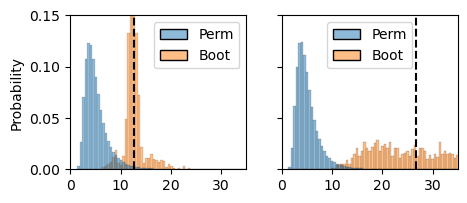

In [44]:
plt.figure(figsize= (5,2), dpi=100)

ax1 = plt.subplot(1,2,1)
ax1 = sns.histplot(data = {'Perm': acRandQBoot, 'Boot': acQBoot}, stat = 'probability', common_norm = False, binwidth = .5)
ax1.axvline(np.mean(acQBoot), color = 'k', linestyle = '--')
ax1.set_xlim(0, 35)
ax1.set_ylim(0, 0.15)
ax1.set_yticks([0, 0.05, 0.1, 0.15])




ax2 = plt.subplot(1,2,2)
ax2 = sns.histplot(data = {'Perm': behRandQBoot, 'Boot': behQBoot}, stat = 'probability', common_norm = False, binwidth = .5)
ax2.axvline(np.mean(behQBoot), color = 'k', linestyle = '--')
ax2.set_xlim(0, 35)
ax2.set_ylim(0, 0.15)
ax2.set_yticks([0, 0.05, 0.1, 0.15], labels = [])
ax2.set_ylabel('')

plt.savefig(figDir + 'BehaviorAcousticPAFWithinBetweenPermutationBootV2.eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


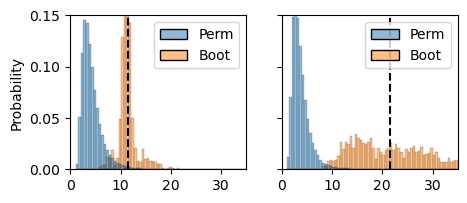

In [45]:
# Smae figure without song

plt.figure(figsize= (5,2), dpi=100)

ax1 = plt.subplot(1,2,1)
ax1 = sns.histplot(data = {'Perm': acRandQBootNoSo, 'Boot': acQBootNoSo}, stat = 'probability', common_norm = False, binwidth = .5)
ax1.axvline(np.mean(acQBootNoSo), color = 'k', linestyle = '--')
ax1.set_xlim(0, 35)
ax1.set_ylim(0, 0.15)
ax1.set_yticks([0, 0.05, 0.1, 0.15])




ax2 = plt.subplot(1,2,2)
ax2 = sns.histplot(data = {'Perm': behRandQBootNoSo, 'Boot': behQBootNoSo}, stat = 'probability', common_norm = False, binwidth = .5)
ax2.axvline(np.mean(behQBootNoSo), color = 'k', linestyle = '--')
ax2.set_xlim(0, 35)
ax2.set_ylim(0, 0.15)
ax2.set_yticks([0, 0.05, 0.1, 0.15], labels = [])
ax2.set_ylabel('')

plt.savefig(figDir + 'BehaviorAcousticPAFWithinBetweenPermutationBootNoSo.eps')
